In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### xgboost

In [2]:
def XGBoostC(train_x, test_x, train_y, test_y, config):
    
    clf = xgb.XGBClassifier(**config, n_jobs = -1, use_label_encoder = False)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result
    
    
def XGBoostR(train_x, test_x, train_y, test_y, config):
    
    reg = xgb.XGBRegressor(**config, n_jobs = -1)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


def runall_XGBoostC(num_set, trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
            
        result = XGBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)    
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_XGBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = XGBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)     
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
    return pr_dict, table_set

### optuna

In [3]:
def XGBoost_creator(train_data, mode, num_valid = 3, label = 'GB') :
    
    def objective(trial) :

        param = {
            'eval_metric': trial.suggest_categorical('eval_metric', ['logloss']),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 24, step = 3),
            'max_depth': trial.suggest_int('max_depth', 3, 13, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 2), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 2) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = XGBoostC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 0.75
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                result_list.append(fscore)

            elif mode == 'R':
                result = XGBoostR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1928, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1514, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1662, 88)  balance ratio: 0.71
Dimension of dataset 7 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (3150, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2480, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 200, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_XGBoost', 
                                     creator = XGBoost_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 20:47:16,806] A new study created in memory with name: no-name-83b15c73-ef37-408c-8805-49f78cd5c86d


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9137931034482759 
Recall: 0.6973684210526315 
Aging Rate: 0.001476315320589508
Precision: 0.9183673469387755 
Recall: 0.5921052631578947 
Aging Rate: 0.0012472319087738946
Precision: 0.8571428571428571 
Recall: 0.631578947368421 
Aging Rate: 0.0014254078957415938
[I 2021-12-12 20:48:16,583] Trial 0 finished with value: 0.782600914164929 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.0012116338245063295, 'reg_lambda': 0.00047696477694941856}. Best is trial 0 with value: 0.782600914164929.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-12 20:48:48,333] Trial 1 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:49:08,808] Trial 2 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:49:37,568] Trial 3 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:50:10,761] Trial 4 failed, because the objective function returned nan.
Precision: 0.6666666666666666 
Recall: 0.02631578947368421 
Aging Rate: 7.63611372718711e-05
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:50:32,155] Trial 5 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:50:59,046] Trial 6 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:51:16,975] Trial 7 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:51:41,654] Trial 8 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:52:06,092] Trial 9 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:52:22,941] Trial 10 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:52:47,288] Trial 11 failed, because the objective function returned nan.
Precision: 0.9 
Recall: 0.11842105263157894 
Aging Rate: 0.00025453712423957034
Precision: 0.6363636363636364 
Recall: 0.09210526315789473 
Aging Rate: 0.0002799908366635274
Precision: 0.6923076923076923 
Recall: 0.11842105263157894 
Aging Rate: 0.00033089826151144145
[I 2021-12-12 20:53:28,274] Trial 12 finished with value: 0.24077273409483646 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.13621024183624095, 'reg_lambda': 0.004854872107265286}. Best is trial 0 with value: 0.782600914164929.
Precision: 0.75 
Recall: 0.11842105263157894 
Aging Rate: 0.0003054445490874844
Precision: 0.8571428571428571 
Recall: 0.07894736842105263 
Aging Rate: 0.00017817598696769923
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.000203

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:54:52,938] Trial 15 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.00010181484969582814
Precision: 0.6 
Recall: 0.039473684210526314 
Aging Rate: 0.00012726856211978517
Precision: 0.75 
Recall: 0.039473684210526314 
Aging Rate: 0.00010181484969582814
[I 2021-12-12 20:55:11,220] Trial 16 finished with value: 0.11070825283945085 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.06455572512502662, 'reg_lambda': 0.014038643997665782}. Best is trial 0 with value: 0.782600914164929.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:55:30,599] Trial 17 failed, because the objective function returned nan.
Precision: 0.8571428571428571 
Recall: 0.07894736842105263 
Aging Rate: 0.00017817598696769923
Precision: 1.0 
Recall: 0.11842105263157894 
Aging Rate: 0.0002290834118156133
Precision: 0.5714285714285714 
Recall: 0.05263157894736842 
Aging Rate: 0.00017817598696769923
[I 2021-12-12 20:56:07,779] Trial 18 finished with value: 0.19526982739785884 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.00020127474110286802, 'reg_lambda': 0.00024256201732906504}. Best is trial 0 with value: 0.782600914164929.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:56:23,975] Trial 19 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:56:45,990] Trial 20 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:57:15,268] Trial 21 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:57:45,867] Trial 22 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:58:10,829] Trial 23 failed, because the objective function returned nan.
Precision: 0.7857142857142857 
Recall: 0.14473684210526316 
Aging Rate: 0.00035635197393539845
Precision: 1.0 
Recall: 0.11842105263157894 
Aging Rate: 0.0002290834118156133
Precision: 0.7272727272727273 
Recall: 0.21052631578947367 
Aging Rate: 0.0005599816733270548
[I 2021-12-12 20:59:21,829] Trial 24 finished with value: 0.3202343175528389 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.01636291454244803, 'reg_lambda': 0.003062128795086223}. Best is trial 0 with value: 0.782600914164929.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:59:43,210] Trial 25 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:00:09,058] Trial 26 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:00:48,593] Trial 27 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:01:46,524] Trial 28 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 7.63611372718711e-05
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 7.63611372718711e-05
Precision: 0.42857142857142855 
Recall: 0.039473684210526314 
Aging Rate: 0.00017817598696769923
[I 2021-12-12 21:02:32,431] Trial 29 finished with value: 0.09971304610484115 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 1.2166614736076455, 'reg_lambda': 0.002645864244985023}. Best is trial 0 with value: 0.782600914164929.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:03:03,884] Trial 30 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:03:27,102] Trial 31 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:03:54,862] Trial 32 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:04:22,050] Trial 33 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:04:57,878] Trial 34 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:05:26,655] Trial 35 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:05:42,459] Trial 36 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:06:03,016] Trial 37 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:06:56,622] Trial 38 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:07:07,319] Trial 39 failed, because the objective function returned nan.
Precision: 0.8 
Recall: 0.10526315789473684 
Aging Rate: 0.00025453712423957034
Precision: 0.4666666666666667 
Recall: 0.09210526315789473 
Aging Rate: 0.0003818056863593555
Precision: 0.8333333333333334 
Recall: 0.13157894736842105 
Aging Rate: 0.0003054445490874844
[I 2021-12-12 21:07:56,219] Trial 40 finished with value: 0.23724963063079016 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 1.9654763070508718, 'reg_lambda': 0.16292068987481276}. Best is trial 0 with value: 0.782600914164929.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:08:21,813] Trial 41 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:09:35,590] Trial 42 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:10:07,040] Trial 43 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:10:48,716] Trial 44 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:11:19,112] Trial 45 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:11:53,584] Trial 46 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.00010181484969582814
Precision: 0.4 
Recall: 0.05263157894736842 
Aging Rate: 0.00025453712423957034
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.00012726856211978517
[I 2021-12-12 21:12:29,259] Trial 47 finished with value: 0.13859527244649786 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.02186334102412881, 'reg_lambda': 0.003254598738156822}. Best is trial 0 with value: 0.782600914164929.
Precision: 0.8301886792452831 
Recall: 0.5789473684210527 
Aging Rate: 0.0013490467584697228
Precision: 0.8 
Recall: 0.5789473684210527 
Aging Rate: 0.0013999541833176368
Precision: 0.8269230769230769 
Recall: 0.5657894736842105 
Aging Rate: 0.0013235930460457658
[I 2021-12-12 21:13:35

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.8 
Recall: 0.05263157894736842 
Aging Rate: 0.00012726856211978517
Precision: 0.6666666666666666 
Recall: 0.02631578947368421 
Aging Rate: 7.63611372718711e-05
[W 2021-12-12 21:14:47,087] Trial 50 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 7.63611372718711e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00010181484969582814
Precision: 0.75 
Recall: 0.039473684210526314 
Aging Rate: 0.00010181484969582814
[W 2021-12-12 21:15:19,973] Trial 51 failed, because the objective function returned nan.
Precision: 0.8974358974358975 
Recall: 0.4605263157894737 
Aging Rate: 0.0009926947845343244
Precision: 0.7333333333333333 
Recall: 0.5789473684210527 
Aging Rate: 0.001527222745437422
Precision: 0.9 
Recall: 0.47368421052631576 
Aging Rate: 0.0010181484969582814
[I 2021-12-12 21:15:54,645] Trial 52 finished with value: 0.6726061031654718 and parameters: {'eval_metric': 'loglo

Precision: 0.8064516129032258 
Recall: 0.6578947368421053 
Aging Rate: 0.001578130170285336
Precision: 0.8928571428571429 
Recall: 0.6578947368421053 
Aging Rate: 0.0014254078957415938
[I 2021-12-12 21:27:15,478] Trial 64 finished with value: 0.737546101734495 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0020151049013889277, 'reg_lambda': 0.00018038279345035043}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:27:24,493] Trial 65 failed, because the objective function returned nan.
Precision: 0.8214285714285714 
Recall: 0.6052631578947368 
Aging Rate: 0.0014254078957415938
Precision: 0.8070175438596491 
Recall: 0.6052631578947368 
Aging Rate: 0.001450861608165551
Precision: 0.8727272727272727 
Recall: 0.631578947368421 
Aging Rate: 0.0013999541833176368
[I 2021-12-12 21:28:21,312] Trial 66 finished with value: 0.7385543022739708 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.015432731730825428, 'reg_lambda': 0.00038955504440984915}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:29:02,761] Trial 67 failed, because the objective function returned nan.
Precision: 0.75 
Recall: 0.15789473684210525 
Aging Rate: 0.00040725939878331256
Precision: 0.5384615384615384 
Recall: 0.09210526315789473 
Aging Rate: 0.00033089826151144145
Precision: 0.6666666666666666 
Recall: 0.15789473684210525 
Aging Rate: 0.0004581668236312266
[I 2021-12-12 21:29:53,777] Trial 68 finished with value: 0.2746597507620098 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00020423499459565564, 'reg_lambda': 0.09002149519299014}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:30:23,757] Trial 69 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:30:44,138] Trial 70 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:31:35,555] Trial 71 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:32:01,746] Trial 72 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:32:31,165] Trial 73 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:33:07,778] Trial 74 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:33:35,649] Trial 75 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:34:00,698] Trial 76 failed, because the objective function returned nan.
Precision: 0.9 
Recall: 0.11842105263157894 
Aging Rate: 0.00025453712423957034
Precision: 0.7777777777777778 
Recall: 0.09210526315789473 
Aging Rate: 0.0002290834118156133
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.00020362969939165628
[I 2021-12-12 21:34:39,670] Trial 77 finished with value: 0.2311525253697532 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00022913998667196551, 'reg_lambda': 0.00010137329414595035}. Best is trial 57 with value: 0.795348161115694.
Precision: 0.6666666666666666 
Recall: 0.2631578947368421 
Aging Rate: 0.000763611372718711
Precision: 0.7714285714285715 
Recall: 0.35526315789473684 
Aging Rate: 0.0008908799348384962
Precision: 0.8484848484848485 
Recall: 0.3684210526315789 
Aging

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:36:08,734] Trial 79 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:36:41,547] Trial 80 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 21:37:08,555] Trial 81 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:37:18,613] Trial 82 failed, because the objective function returned nan.
Precision: 0.8918918918918919 
Recall: 0.4342105263157895 
Aging Rate: 0.0009417873596864102
Precision: 0.8809523809523809 
Recall: 0.4868421052631579 
Aging Rate: 0.0010690559218061954
Precision: 0.775 
Recall: 0.40789473684210525 
Aging Rate: 0.0010181484969582814
[I 2021-12-12 21:38:01,575] Trial 83 finished with value: 0.6380175161641612 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0012605572830818605, 'reg_lambda': 0.00019127210476314096}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:38:14,165] Trial 84 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:38:29,170] Trial 85 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:39:08,376] Trial 86 failed, because the objective function returned nan.
Precision: 0.796875 
Recall: 0.6710526315789473 
Aging Rate: 0.0016290375951332503
Precision: 0.8035714285714286 
Recall: 0.5921052631578947 
Aging Rate: 0.0014254078957415938
Precision: 0.9285714285714286 
Recall: 0.6842105263157895 
Aging Rate: 0.0014254078957415938
[I 2021-12-12 21:39:54,444] Trial 87 finished with value: 0.7604324153400724 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0002957716239071671, 'reg_lambda': 0.011546325628175343}. Best is trial 57 with value: 0.795348161115694.
Precision: 0.7647058823529411 
Recall: 0.17105263157894737 
Aging Rate: 0.00043271311120726956
Precision: 0.7142857142857143 
Recall: 0.19736842105263158 
Aging Rate: 0.0005345279609030977
Precision: 0.8125 
Recall: 0.17105263157894737 
Aging Rate: 0.000

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:45:23,965] Trial 95 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:45:54,906] Trial 96 failed, because the objective function returned nan.
Precision: 0.8333333333333334 
Recall: 0.5263157894736842 
Aging Rate: 0.0012217781963499376
Precision: 0.8571428571428571 
Recall: 0.5526315789473685 
Aging Rate: 0.0012472319087738946
Precision: 0.9534883720930233 
Recall: 0.5394736842105263 
Aging Rate: 0.0010945096342301526
[I 2021-12-12 21:46:48,929] Trial 97 finished with value: 0.7170162126168557 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.0002118596785678325, 'reg_lambda': 0.015329243293719633}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:46:59,546] Trial 98 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:47:17,291] Trial 99 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:47:41,056] Trial 100 failed, because the objective function returned nan.
Precision: 0.9183673469387755 
Recall: 0.5921052631578947 
Aging Rate: 0.0012472319087738946
Precision: 0.8541666666666666 
Recall: 0.5394736842105263 
Aging Rate: 0.0012217781963499376
Precision: 0.8333333333333334 
Recall: 0.5921052631578947 
Aging Rate: 0.0013745004708936798
[I 2021-12-12 21:48:39,266] Trial 101 finished with value: 0.7330052749674157 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.0001049956569307906, 'reg_lambda': 0.0002521226850019061}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:49:06,981] Trial 102 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:49:19,315] Trial 103 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:49:40,132] Trial 104 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:50:00,212] Trial 105 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:50:19,615] Trial 106 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:50:30,230] Trial 107 failed, because the objective function returned nan.
Precision: 0.7971014492753623 
Recall: 0.7236842105263158 
Aging Rate: 0.0017563061572530353
Precision: 0.8360655737704918 
Recall: 0.6710526315789473 
Aging Rate: 0.001552676457861379
Precision: 0.8709677419354839 
Recall: 0.7105263157894737 
Aging Rate: 0.001578130170285336
[I 2021-12-12 21:51:21,338] Trial 108 finished with value: 0.7808590697516941 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0001335820347365979, 'reg_lambda': 0.010399603695613747}. Best is trial 57 with value: 0.795348161115694.
Precision: 0.75 
Recall: 0.47368421052631576 
Aging Rate: 0.0012217781963499376
Precision: 0.8478260869565217 
Recall: 0.5131578947368421 
Aging Rate: 0.0011708707715020236
Precision: 0.8333333333333334 
Recall: 0.39473684210526316

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:53:13,635] Trial 111 failed, because the objective function returned nan.
Precision: 0.8363636363636363 
Recall: 0.6052631578947368 
Aging Rate: 0.0013999541833176368
Precision: 0.8222222222222222 
Recall: 0.4868421052631579 
Aging Rate: 0.0011454170590780666
Precision: 0.7254901960784313 
Recall: 0.4868421052631579 
Aging Rate: 0.0012981393336218088
[I 2021-12-12 21:53:54,127] Trial 112 finished with value: 0.6702642310485448 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00014172849662805252, 'reg_lambda': 0.003964753612724421}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:54:12,708] Trial 113 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:54:31,913] Trial 114 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:54:46,817] Trial 115 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:55:23,889] Trial 116 failed, because the objective function returned nan.
Precision: 0.8148148148148148 
Recall: 0.5789473684210527 
Aging Rate: 0.0013745004708936798
Precision: 0.813953488372093 
Recall: 0.4605263157894737 
Aging Rate: 0.0010945096342301526
Precision: 0.8461538461538461 
Recall: 0.5789473684210527 
Aging Rate: 0.0013235930460457658
[I 2021-12-12 21:56:16,873] Trial 117 finished with value: 0.6913143616108228 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0002723474328014629, 'reg_lambda': 0.009224277027560237}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:56:47,943] Trial 118 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:57:16,578] Trial 119 failed, because the objective function returned nan.
Precision: 0.7894736842105263 
Recall: 0.5921052631578947 
Aging Rate: 0.001450861608165551
Precision: 0.7142857142857143 
Recall: 0.5921052631578947 
Aging Rate: 0.0016035838827092933
Precision: 0.7719298245614035 
Recall: 0.5789473684210527 
Aging Rate: 0.001450861608165551
[I 2021-12-12 21:58:07,951] Trial 120 finished with value: 0.6863346309035 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00010639702505328745, 'reg_lambda': 0.006666718158009697}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:58:42,051] Trial 121 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:59:03,424] Trial 122 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:59:21,387] Trial 123 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:00:02,566] Trial 124 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 7.63611372718711e-05
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 7.63611372718711e-05
[I 2021-12-12 22:00:23,694] Trial 125 finished with value: 0.08021077283372365 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.10050746231278228, 'reg_lambda': 0.380349981270388}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:00:50,306] Trial 126 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:01:10,512] Trial 127 failed, because the objective function returned nan.
Precision: 0.75 
Recall: 0.039473684210526314 
Aging Rate: 0.00010181484969582814
Precision: 0.625 
Recall: 0.06578947368421052 
Aging Rate: 0.00020362969939165628
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 0.00017817598696769923
[I 2021-12-12 22:02:01,816] Trial 128 finished with value: 0.15801917086993586 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.00014495935749837824, 'reg_lambda': 0.05335155661354305}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:02:24,014] Trial 129 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:02:53,311] Trial 130 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:03:09,145] Trial 131 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:03:25,064] Trial 132 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:03:58,419] Trial 133 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:04:11,374] Trial 134 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:04:28,140] Trial 135 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:04:56,782] Trial 136 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:05:08,063] Trial 137 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:05:21,554] Trial 138 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:05:52,702] Trial 139 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:06:10,832] Trial 140 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:06:48,218] Trial 141 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:07:11,655] Trial 142 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:08:01,412] Trial 143 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:08:39,160] Trial 144 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:08:59,562] Trial 145 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:09:08,422] Trial 146 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:09:47,327] Trial 147 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:10:08,575] Trial 148 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:10:29,074] Trial 149 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:10:48,742] Trial 150 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:11:25,097] Trial 151 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:11:38,861] Trial 152 failed, because the objective function returned nan.
Precision: 0.8392857142857143 
Recall: 0.618421052631579 
Aging Rate: 0.0014254078957415938
Precision: 0.875 
Recall: 0.5526315789473685 
Aging Rate: 0.0012217781963499376
Precision: 0.765625 
Recall: 0.6447368421052632 
Aging Rate: 0.0016290375951332503
[I 2021-12-12 22:12:28,942] Trial 153 finished with value: 0.7280081655659387 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0011608666693910447, 'reg_lambda': 0.0025258976068944063}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:13:10,919] Trial 154 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:14:28,876] Trial 155 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:14:38,136] Trial 156 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:14:54,858] Trial 157 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:15:16,078] Trial 158 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:15:31,604] Trial 159 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:15:42,424] Trial 160 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:16:06,584] Trial 161 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:16:28,297] Trial 162 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:16:58,840] Trial 163 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:17:20,952] Trial 164 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:17:48,361] Trial 165 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:18:05,148] Trial 166 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:18:26,214] Trial 167 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:18:42,533] Trial 168 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:18:57,752] Trial 169 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:19:21,494] Trial 170 failed, because the objective function returned nan.
Precision: 0.5882352941176471 
Recall: 0.13157894736842105 
Aging Rate: 0.00043271311120726956
Precision: 0.8235294117647058 
Recall: 0.18421052631578946 
Aging Rate: 0.00043271311120726956
Precision: 0.8823529411764706 
Recall: 0.19736842105263158 
Aging Rate: 0.00043271311120726956
[I 2021-12-12 22:19:56,656] Trial 171 finished with value: 0.33995815899581583 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.17578905057221986, 'reg_lambda': 0.6705660785540366}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:20:13,797] Trial 172 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:20:37,122] Trial 173 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:21:07,377] Trial 174 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:21:39,080] Trial 175 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:21:51,033] Trial 176 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:22:14,872] Trial 177 failed, because the objective function returned nan.
Precision: 0.6875 
Recall: 0.14473684210526316 
Aging Rate: 0.00040725939878331256
Precision: 0.7647058823529411 
Recall: 0.17105263157894737 
Aging Rate: 0.00043271311120726956
Precision: 0.5714285714285714 
Recall: 0.10526315789473684 
Aging Rate: 0.00035635197393539845
[I 2021-12-12 22:22:37,006] Trial 178 finished with value: 0.2842585558885981 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 1.3518533715915357, 'reg_lambda': 0.00211432489728192}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:22:55,981] Trial 179 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:23:25,003] Trial 180 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:24:05,680] Trial 181 failed, because the objective function returned nan.
Precision: 0.8695652173913043 
Recall: 0.5263157894736842 
Aging Rate: 0.0011708707715020236
Precision: 0.92 
Recall: 0.6052631578947368 
Aging Rate: 0.0012726856211978518
Precision: 0.8679245283018868 
Recall: 0.6052631578947368 
Aging Rate: 0.0013490467584697228
[I 2021-12-12 22:24:48,867] Trial 182 finished with value: 0.7432702360607641 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0005291638155885454, 'reg_lambda': 0.0003092420125852694}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:25:25,974] Trial 183 failed, because the objective function returned nan.
Precision: 0.9019607843137255 
Recall: 0.6052631578947368 
Aging Rate: 0.0012981393336218088
Precision: 0.9090909090909091 
Recall: 0.6578947368421053 
Aging Rate: 0.0013999541833176368
Precision: 0.8301886792452831 
Recall: 0.5789473684210527 
Aging Rate: 0.0013490467584697228
[I 2021-12-12 22:26:29,608] Trial 184 finished with value: 0.7613050230119672 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.0016827842244461018, 'reg_lambda': 0.0003019885529952923}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:26:44,489] Trial 185 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:27:10,762] Trial 186 failed, because the objective function returned nan.
Precision: 0.8333333333333334 
Recall: 0.19736842105263158 
Aging Rate: 0.0004581668236312266
Precision: 0.7857142857142857 
Recall: 0.2894736842105263 
Aging Rate: 0.0007127039478707969
Precision: 0.8 
Recall: 0.21052631578947367 
Aging Rate: 0.0005090742484791407
[I 2021-12-12 22:27:58,644] Trial 187 finished with value: 0.4233581893398067 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.00311553820223484, 'reg_lambda': 0.0004968570943602684}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:28:11,615] Trial 188 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:28:36,031] Trial 189 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:28:58,472] Trial 190 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:29:19,476] Trial 191 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:29:40,243] Trial 192 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:30:13,301] Trial 193 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:30:32,908] Trial 194 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:30:48,598] Trial 195 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:31:34,831] Trial 196 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:31:55,106] Trial 197 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.00020362969939165628
Precision: 0.8 
Recall: 0.05263157894736842 
Aging Rate: 0.00012726856211978517
Precision: 0.6666666666666666 
Recall: 0.10526315789473684 
Aging Rate: 0.0003054445490874844
[I 2021-12-12 22:32:51,834] Trial 198 finished with value: 0.20183532445277927 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.004531630954253075, 'reg_lambda': 0.00012651954456345784}. Best is trial 57 with value: 0.795348161115694.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 22:33:11,313] A new study created in memory with name: no-name-a9581ccc-7e7a-4f47-91de-57620e46704b


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:33:11,203] Trial 199 failed, because the objective function returned nan.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9652406417112299 
Recall: 0.9413298565840938 
Aging Rate: 0.4876140808344198
Precision: 0.9489528795811518 
Recall: 0.9452411994784876 
Aging Rate: 0.4980443285528031
Precision: 0.965287049399199 
Recall: 0.9426336375488917 
Aging Rate: 0.48826597131681876
[I 2021-12-12 22:33:13,061] Trial 0 finished with value: 0.9537049594660799 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00025219362875815985, 'reg_lambda': 0.005883799542102329}. Best is trial 0 with value: 0.9537049594660799.
Precision: 0.9777486910994765 
Recall: 0.9739243807040417 
Aging Rate: 0.4980443285528031
Precision: 0.9725490196078431 
Recall: 0.970013037809648 
Aging Rate: 0.49869621903520206
Precision: 0.9640102827763496 
Recall: 0.9778357235984355 
Aging Rate: 0.5071707953063885
[I 2021-12-12 22:33:15,477] Trial 1 finished with value: 0.9723150659711122 and parameters: {'eval_met

Precision: 0.9780927835051546 
Recall: 0.9895697522816167 
Aging Rate: 0.5058670143415906
Precision: 0.9704749679075738 
Recall: 0.9856584093872229 
Aging Rate: 0.5078226857887875
Precision: 0.9790575916230366 
Recall: 0.9752281616688396 
Aging Rate: 0.4980443285528031
[I 2021-12-12 22:33:31,940] Trial 13 finished with value: 0.9785853501024652 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.1636019054461442, 'reg_lambda': 0.014716599363207954}. Best is trial 10 with value: 0.9893215800494651.
Precision: 0.9868247694334651 
Recall: 0.9765319426336375 
Aging Rate: 0.49478487614080835
Precision: 0.9755469755469756 
Recall: 0.9882659713168188 
Aging Rate: 0.5065189048239895
Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
[I 2021-12-12 22:33:33,589] Trial 14 finished with value: 0.9846113842610941 and parameters: {'eval_met

Precision: 0.9732824427480916 
Recall: 0.9973924380704041 
Aging Rate: 0.5123859191655802
Precision: 0.9818181818181818 
Recall: 0.9856584093872229 
Aging Rate: 0.5019556714471969
[I 2021-12-12 22:33:54,272] Trial 26 finished with value: 0.9807351867836712 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.005574129278294123, 'reg_lambda': 0.8981972202502134}. Best is trial 20 with value: 0.9903684422996094.
Precision: 0.9624352331606217 
Recall: 0.9687092568448501 
Aging Rate: 0.5032594524119948
Precision: 0.9647979139504563 
Recall: 0.9647979139504563 
Aging Rate: 0.5
Precision: 0.9724770642201835 
Recall: 0.9674054758800521 
Aging Rate: 0.4973924380704042
[I 2021-12-12 22:33:56,601] Trial 27 finished with value: 0.9667091965510685 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 18, 'max_depth': 7, 'learning_r

Precision: 0.9757343550446999 
Recall: 0.9960886571056062 
Aging Rate: 0.5104302477183833
[I 2021-12-12 22:34:21,538] Trial 39 finished with value: 0.982784590691717 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.0002963326489616406, 'reg_lambda': 0.6667145159352172}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
Precision: 0.9857512953367875 
Recall: 0.9921773142112125 
Aging Rate: 0.5032594524119948
[I 2021-12-12 22:34:23,691] Trial 40 finished with value: 0.9905271299618089 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0002134888572701693, 'reg_lambda': 1.1023520608224877}. Best is trial 32 with value: 0.

Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
Precision: 0.9856396866840731 
Recall: 0.984354628422425 
Aging Rate: 0.49934810951760106
Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
[I 2021-12-12 22:34:49,666] Trial 53 finished with value: 0.9886995725560096 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.00013727146322268374, 'reg_lambda': 1.054540947537242}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9720744680851063 
Recall: 0.9530638852672751 
Aging Rate: 0.49022164276401564
Precision: 0.9879518072289156 
Recall: 0.9621903520208605 
Aging Rate: 0.4869621903520209
Precision: 0.9628154050464808 
Recall: 0.9452411994784876 
Aging Rate: 0.4908735332464146
[I 2021-12-12 22:34:50,658] Trial 54 finished with value: 0.966692703113437 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, '

Precision: 0.9857512953367875 
Recall: 0.9921773142112125 
Aging Rate: 0.5032594524119948
Precision: 0.9857142857142858 
Recall: 0.9895697522816167 
Aging Rate: 0.5019556714471969
[I 2021-12-12 22:35:17,965] Trial 66 finished with value: 0.9876016431804097 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.00025130259497887207, 'reg_lambda': 0.005284786440623495}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9921156373193167 
Recall: 0.984354628422425 
Aging Rate: 0.49608865710560623
Precision: 0.9857881136950905 
Recall: 0.9947848761408083 
Aging Rate: 0.5045632333767927
Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
[I 2021-12-12 22:35:20,829] Trial 67 finished with value: 0.989020159996869 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate'

Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
[I 2021-12-12 22:35:51,431] Trial 79 finished with value: 0.9883633044191326 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.004729063496129568, 'reg_lambda': 0.0002175242399100007}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9503355704697987 
Recall: 0.9230769230769231 
Aging Rate: 0.48565840938722293
Precision: 0.9532085561497327 
Recall: 0.9295958279009127 
Aging Rate: 0.4876140808344198
Precision: 0.9566360052562418 
Recall: 0.9491525423728814 
Aging Rate: 0.49608865710560623
[I 2021-12-12 22:35:52,447] Trial 80 finished with value: 0.9462794616367742 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0005093593235586556, 'reg_lambda': 0.000175850109408352}

Precision: 0.9831387808041504 
Recall: 0.9882659713168188 
Aging Rate: 0.5026075619295959
[I 2021-12-12 22:36:23,051] Trial 92 finished with value: 0.9893117373271346 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.00011796970636669451, 'reg_lambda': 0.2510659107393868}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9844961240310077 
Recall: 0.9934810951760105 
Aging Rate: 0.5045632333767927
Precision: 0.9857697283311773 
Recall: 0.9934810951760105 
Aging Rate: 0.5039113428943938
[I 2021-12-12 22:36:26,518] Trial 93 finished with value: 0.9904619162300748 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.0006077525330384837, 'reg_lambda': 0.3085646155796423}. Bes

Precision: 0.9743589743589743 
Recall: 0.9908735332464146 
Aging Rate: 0.5084745762711864
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9806701030927835 
Recall: 0.9921773142112125 
Aging Rate: 0.5058670143415906
[I 2021-12-12 22:37:03,068] Trial 106 finished with value: 0.98486399671566 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.00017490110361037062, 'reg_lambda': 1.7178111380152061}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9768934531450578 
Recall: 0.9921773142112125 
Aging Rate: 0.5078226857887875
Precision: 0.9794608472400513 
Recall: 0.9947848761408083 
Aging Rate: 0.5078226857887875
Precision: 0.9782886334610472 
Recall: 0.9986962190352021 
Aging Rate: 0.5104302477183833
[I 2021-12-12 22:37:06,279] Trial 107 finished with value: 0.9842674916329736 and parameters: {'eval_metric': 'logloss', 'n_estimator

Precision: 0.9882659713168188 
Recall: 0.9882659713168188 
Aging Rate: 0.5
Precision: 0.9960474308300395 
Recall: 0.9856584093872229 
Aging Rate: 0.49478487614080835
[I 2021-12-12 22:37:33,472] Trial 119 finished with value: 0.9914613624621441 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.0002512339482490308, 'reg_lambda': 1.1755806117232606}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9869109947643979 
Recall: 0.9830508474576272 
Aging Rate: 0.4980443285528031
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
Precision: 0.9805950840879689 
Recall: 0.9882659713168188 
Aging Rate: 0.5039113428943938
[I 2021-12-12 22:37:35,630] Trial 120 finished with value: 0.986259562264424 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.175

Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
[I 2021-12-12 22:38:03,624] Trial 132 finished with value: 0.9876833921805351 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0022688159353189017, 'reg_lambda': 0.2920540257502492}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9830949284785435 
Recall: 0.9856584093872229 
Aging Rate: 0.5013037809647979
Precision: 0.9882659713168188 
Recall: 0.9882659713168188 
Aging Rate: 0.5
Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
[I 2021-12-12 22:38:05,272] Trial 133 finished with value: 0.9876446647177541 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning

Precision: 0.9792746113989638 
Recall: 0.9856584093872229 
Aging Rate: 0.5032594524119948
Precision: 0.9732824427480916 
Recall: 0.9973924380704041 
Aging Rate: 0.5123859191655802
[I 2021-12-12 22:38:28,545] Trial 145 finished with value: 0.98356529256111 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.12143397454714736, 'reg_lambda': 0.01563276460170046}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9641943734015346 
Recall: 0.9830508474576272 
Aging Rate: 0.5097783572359843
Precision: 0.9656050955414013 
Recall: 0.9882659713168188 
Aging Rate: 0.5117340286831812
Precision: 0.9666238767650834 
Recall: 0.9817470664928292 
Aging Rate: 0.5078226857887875
[I 2021-12-12 22:38:30,288] Trial 146 finished with value: 0.9721851120930478 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth':

Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
[I 2021-12-12 22:38:54,951] Trial 158 finished with value: 0.9880988046729939 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00027876225732979387, 'reg_lambda': 1.970446377221458}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9895561357702349 
Recall: 0.9882659713168188 
Aging Rate: 0.49934810951760106
Precision: 0.9895561357702349 
Recall: 0.9882659713168188 
Aging Rate: 0.49934810951760106
Precision: 0.9856770833333334 
Recall: 0.9869621903520208 
Aging Rate: 0.500651890482399
[I 2021-12-12 22:38:57,837] Trial 159 finished with value: 0.9881073045086431 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_dep

Precision: 0.9817708333333334 
Recall: 0.9830508474576272 
Aging Rate: 0.500651890482399
Precision: 0.9780927835051546 
Recall: 0.9895697522816167 
Aging Rate: 0.5058670143415906
[I 2021-12-12 22:39:23,342] Trial 171 finished with value: 0.9812401949987724 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.050946373915365065, 'reg_lambda': 0.03890847439425848}. Best is trial 32 with value: 0.9923771696046942.
Precision: 0.9776609724047306 
Recall: 0.970013037809648 
Aging Rate: 0.49608865710560623
Precision: 0.9681697612732095 
Recall: 0.9517601043024772 
Aging Rate: 0.4915254237288136
Precision: 0.9633986928104575 
Recall: 0.9608865710560626 
Aging Rate: 0.49869621903520206
[I 2021-12-12 22:39:24,995] Trial 172 finished with value: 0.9665280601673988 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth

Precision: 0.9870466321243523 
Recall: 0.9934810951760105 
Aging Rate: 0.5032594524119948
Precision: 0.9883268482490273 
Recall: 0.9934810951760105 
Aging Rate: 0.5026075619295959
[I 2021-12-12 22:39:52,658] Trial 184 finished with value: 0.9883293139318506 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0006082061671999659, 'reg_lambda': 0.5886727399191326}. Best is trial 178 with value: 0.9925445912904531.
Precision: 0.99609375 
Recall: 0.9973924380704041 
Aging Rate: 0.500651890482399
Precision: 0.9831387808041504 
Recall: 0.9882659713168188 
Aging Rate: 0.5026075619295959
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
[I 2021-12-12 22:39:55,750] Trial 185 finished with value: 0.9908042834649713 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate':

Precision: 0.9857328145265889 
Recall: 0.9908735332464146 
Aging Rate: 0.5026075619295959
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
[I 2021-12-12 22:40:26,414] Trial 197 finished with value: 0.9891588146504994 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0002696503882040976, 'reg_lambda': 0.0026017763713510164}. Best is trial 178 with value: 0.9925445912904531.
Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
Precision: 0.9805950840879689 
Recall: 0.9882659713168188 
Aging Rate: 0.5039113428943938
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
[I 2021-12-12 22:40:28,784] Trial 198 finished with value: 0.9895913317203299 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'lea

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 22:40:31,603] A new study created in memory with name: no-name-922bdc94-0abe-44db-806c-0adfbf7c24fc


Precision: 0.9857881136950905 
Recall: 0.9947848761408083 
Aging Rate: 0.5045632333767927
[I 2021-12-12 22:40:31,509] Trial 199 finished with value: 0.988719848838267 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0006624349637604002, 'reg_lambda': 0.0010733726897543367}. Best is trial 178 with value: 0.9925445912904531.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9718045112781954 
Recall: 0.9828897338403042 
Aging Rate: 0.5057034220532319
Precision: 0.9783018867924528 
Recall: 0.9857414448669202 
Aging Rate: 0.5038022813688213
Precision: 0.9718045112781954 
Recall: 0.9828897338403042 
Aging Rate: 0.5057034220532319
[I 2021-12-12 22:40:33,671] Trial 0 finished with value: 0.9774998980571113 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 1.0771677396474226, 'reg_lambda': 0.001411950544925961}. Best is trial 0 with value: 0.9774998980571113.
Precision: 0.9604891815616181 
Recall: 0.970532319391635 
Aging Rate: 0.5052281368821293
Precision: 0.9632422243166824 
Recall: 0.9714828897338403 
Aging Rate: 0.504277566539924
Precision: 0.9660056657223796 
Recall: 0.9724334600760456 
Aging Rate: 0.5033269961977186
[I 2021-12-12 22:40:36,593] Trial 1 finished with value: 0.9661944150384976 and parameters: {'eval_metric': 'logloss', 'n_

Precision: 0.9875954198473282 
Recall: 0.9838403041825095 
Aging Rate: 0.49809885931558934
Precision: 0.9792843691148776 
Recall: 0.9885931558935361 
Aging Rate: 0.5047528517110266
[I 2021-12-12 22:41:03,070] Trial 13 finished with value: 0.9835982374527407 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.06800730550019404, 'reg_lambda': 0.0001250821653098065}. Best is trial 11 with value: 0.9864831674375124.
Precision: 0.9829383886255925 
Recall: 0.9857414448669202 
Aging Rate: 0.501425855513308
Precision: 0.985632183908046 
Recall: 0.9781368821292775 
Aging Rate: 0.49619771863117873
Precision: 0.9847764034253093 
Recall: 0.9838403041825095 
Aging Rate: 0.4995247148288973
[I 2021-12-12 22:41:06,617] Trial 14 finished with value: 0.9837685105560837 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 13, 'learni

Precision: 0.976145038167939 
Recall: 0.9724334600760456 
Aging Rate: 0.49809885931558934
Precision: 0.9743833017077799 
Recall: 0.9762357414448669 
Aging Rate: 0.5009505703422054
[I 2021-12-12 22:41:44,138] Trial 26 finished with value: 0.9763564401326764 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.033317710749823086, 'reg_lambda': 0.0002496637678228712}. Best is trial 11 with value: 0.9864831674375124.
Precision: 0.973659454374412 
Recall: 0.9838403041825095 
Aging Rate: 0.5052281368821293
Precision: 0.9755639097744361 
Recall: 0.9866920152091255 
Aging Rate: 0.5057034220532319
Precision: 0.9830348727615457 
Recall: 0.9914448669201521 
Aging Rate: 0.504277566539924
[I 2021-12-12 22:41:46,194] Trial 27 finished with value: 0.9809623912926272 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 7, 'learning

Precision: 0.9848341232227488 
Recall: 0.9876425855513308 
Aging Rate: 0.501425855513308
[I 2021-12-12 22:42:15,344] Trial 39 finished with value: 0.9844713901735664 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.16181334190986807, 'reg_lambda': 0.02307645468954298}. Best is trial 11 with value: 0.9864831674375124.
Precision: 0.9737335834896811 
Recall: 0.9866920152091255 
Aging Rate: 0.5066539923954373
Precision: 0.9628597957288765 
Recall: 0.9857414448669202 
Aging Rate: 0.5118821292775665
Precision: 0.9727699530516432 
Recall: 0.9847908745247148 
Aging Rate: 0.5061787072243346
[I 2021-12-12 22:42:17,289] Trial 40 finished with value: 0.9754655108666376 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.019020354154773367, 'reg_lambda': 0.15754365660233977}. Best 

Precision: 0.975609756097561 
Recall: 0.9885931558935361 
Aging Rate: 0.5066539923954373
Precision: 0.9829383886255925 
Recall: 0.9857414448669202 
Aging Rate: 0.501425855513308
Precision: 0.9680451127819549 
Recall: 0.9790874524714829 
Aging Rate: 0.5057034220532319
[I 2021-12-12 22:42:48,737] Trial 53 finished with value: 0.9787271673945601 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.004130998942357184, 'reg_lambda': 0.007755256098780828}. Best is trial 11 with value: 0.9864831674375124.
Precision: 0.9829545454545454 
Recall: 0.9866920152091255 
Aging Rate: 0.5019011406844106
Precision: 0.9820754716981132 
Recall: 0.9895437262357415 
Aging Rate: 0.5038022813688213
Precision: 0.9820923656927427 
Recall: 0.9904942965779467 
Aging Rate: 0.504277566539924
[I 2021-12-12 22:42:50,798] Trial 54 finished with value: 0.9847161266300097 and parameters: {'eval_metric': 'logloss',

Precision: 0.9821428571428571 
Recall: 0.9933460076045627 
Aging Rate: 0.5057034220532319
Precision: 0.9885167464114832 
Recall: 0.9819391634980988 
Aging Rate: 0.49667300380228135
Precision: 0.9867298578199052 
Recall: 0.9895437262357415 
Aging Rate: 0.501425855513308
[I 2021-12-12 22:43:22,387] Trial 66 finished with value: 0.9866754852574632 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.002844964056275449, 'reg_lambda': 0.016657711842066908}. Best is trial 66 with value: 0.9866754852574632.
Precision: 0.9801324503311258 
Recall: 0.9847908745247148 
Aging Rate: 0.5023764258555133
Precision: 0.9820075757575758 
Recall: 0.9857414448669202 
Aging Rate: 0.5019011406844106
Precision: 0.9810785241248817 
Recall: 0.9857414448669202 
Aging Rate: 0.5023764258555133
[I 2021-12-12 22:43:26,118] Trial 67 finished with value: 0.9826349959071091 and parameters: {'eval_metric': 'logloss

Precision: 0.9809705042816366 
Recall: 0.9800380228136882 
Aging Rate: 0.4995247148288973
Precision: 0.9848341232227488 
Recall: 0.9876425855513308 
Aging Rate: 0.501425855513308
[I 2021-12-12 22:44:00,397] Trial 79 finished with value: 0.9834745282984504 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.015593741065113752, 'reg_lambda': 0.0034652835819183217}. Best is trial 66 with value: 0.9866754852574632.
Precision: 0.9801324503311258 
Recall: 0.9847908745247148 
Aging Rate: 0.5023764258555133
Precision: 0.9858088930936613 
Recall: 0.9904942965779467 
Aging Rate: 0.5023764258555133
Precision: 0.9847036328871893 
Recall: 0.9790874524714829 
Aging Rate: 0.49714828897338403
[I 2021-12-12 22:44:03,396] Trial 80 finished with value: 0.9839897737496898 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth

Precision: 0.9505135387488328 
Recall: 0.967680608365019 
Aging Rate: 0.5090304182509505
Precision: 0.9608404966571156 
Recall: 0.9562737642585551 
Aging Rate: 0.4976235741444867
[I 2021-12-12 22:44:43,276] Trial 92 finished with value: 0.9542328268877925 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0035503706671905625, 'reg_lambda': 1.942835459056408}. Best is trial 66 with value: 0.9866754852574632.
Precision: 0.9802073515551367 
Recall: 0.9885931558935361 
Aging Rate: 0.504277566539924
Precision: 0.9895337773549001 
Recall: 0.9885931558935361 
Aging Rate: 0.4995247148288973
Precision: 0.9821092278719398 
Recall: 0.9914448669201521 
Aging Rate: 0.5047528517110266
[I 2021-12-12 22:44:48,180] Trial 93 finished with value: 0.9859514949305735 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 

Precision: 0.9773584905660377 
Recall: 0.9847908745247148 
Aging Rate: 0.5038022813688213
[I 2021-12-12 22:45:34,236] Trial 105 finished with value: 0.9802136986692386 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.03433602715458597, 'reg_lambda': 0.008180972841709275}. Best is trial 96 with value: 0.9878572420992553.
Precision: 0.9792648444863337 
Recall: 0.9876425855513308 
Aging Rate: 0.504277566539924
Precision: 0.9820923656927427 
Recall: 0.9904942965779467 
Aging Rate: 0.504277566539924
Precision: 0.9830028328611898 
Recall: 0.9895437262357415 
Aging Rate: 0.5033269961977186
[I 2021-12-12 22:45:37,895] Trial 106 finished with value: 0.9842375223392473 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.0014174655363491482, 'reg_lambda': 0.0506859215

Precision: 0.947565543071161 
Recall: 0.9619771863117871 
Aging Rate: 0.5076045627376425
[I 2021-12-12 22:46:24,170] Trial 118 finished with value: 0.9514160040907398 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.0005638003806632415, 'reg_lambda': 0.00015066844003506266}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9829867674858223 
Recall: 0.9885931558935361 
Aging Rate: 0.502851711026616
Precision: 0.9811320754716981 
Recall: 0.9885931558935361 
Aging Rate: 0.5038022813688213
Precision: 0.9820415879017014 
Recall: 0.9876425855513308 
Aging Rate: 0.502851711026616
[I 2021-12-12 22:46:27,854] Trial 119 finished with value: 0.9842844653007043 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.023658148754460217, 'reg_lambda': 0.06820403672459216}.

Precision: 0.9774647887323944 
Recall: 0.9895437262357415 
Aging Rate: 0.5061787072243346
[I 2021-12-12 22:47:14,153] Trial 131 finished with value: 0.983129208805451 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.13840280079599182, 'reg_lambda': 0.009118091213290111}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9857006673021925 
Recall: 0.9828897338403042 
Aging Rate: 0.498574144486692
Precision: 0.9793038570084666 
Recall: 0.9895437262357415 
Aging Rate: 0.5052281368821293
Precision: 0.9719363891487371 
Recall: 0.9876425855513308 
Aging Rate: 0.5080798479087453
[I 2021-12-12 22:47:19,143] Trial 132 finished with value: 0.9817284423400524 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.20560284173698723, 'reg_lambda': 0.0005268096

Precision: 0.9811853245531514 
Recall: 0.9914448669201521 
Aging Rate: 0.5052281368821293
Precision: 0.9848341232227488 
Recall: 0.9876425855513308 
Aging Rate: 0.501425855513308
Precision: 0.9914448669201521 
Recall: 0.9914448669201521 
Aging Rate: 0.5
[I 2021-12-12 22:48:03,457] Trial 145 finished with value: 0.9873808007570641 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.8102290566354209, 'reg_lambda': 0.00025737445458832135}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9857278782112274 
Recall: 0.9847908745247148 
Aging Rate: 0.4995247148288973
Precision: 0.9820075757575758 
Recall: 0.9857414448669202 
Aging Rate: 0.5019011406844106
Precision: 0.9923882017126546 
Recall: 0.9914448669201521 
Aging Rate: 0.4995247148288973
[I 2021-12-12 22:48:07,109] Trial 146 finished with value: 0.9869290838476763 and parameters: {'eval_metric': 'loglo

Precision: 0.9848341232227488 
Recall: 0.9876425855513308 
Aging Rate: 0.501425855513308
Precision: 0.9810964083175804 
Recall: 0.9866920152091255 
Aging Rate: 0.502851711026616
Precision: 0.9802816901408451 
Recall: 0.9923954372623575 
Aging Rate: 0.5061787072243346
[I 2021-12-12 22:48:41,970] Trial 158 finished with value: 0.9845184161322632 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 1.1193533049607884, 'reg_lambda': 0.0002941863292877252}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9875598086124402 
Recall: 0.9809885931558935 
Aging Rate: 0.49667300380228135
Precision: 0.981904761904762 
Recall: 0.9800380228136882 
Aging Rate: 0.4990494296577947
Precision: 0.9783223374175306 
Recall: 0.9866920152091255 
Aging Rate: 0.504277566539924
[I 2021-12-12 22:48:44,953] Trial 159 finished with value: 0.9825783282305286 and parameters: {'eval_metric': 'logloss'

Precision: 0.9876308277830638 
Recall: 0.9866920152091255 
Aging Rate: 0.4995247148288973
Precision: 0.9801324503311258 
Recall: 0.9847908745247148 
Aging Rate: 0.5023764258555133
[I 2021-12-12 22:49:21,059] Trial 171 finished with value: 0.984931344944755 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.0002688527177080854, 'reg_lambda': 0.1309713231045323}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9792452830188679 
Recall: 0.9866920152091255 
Aging Rate: 0.5038022813688213
Precision: 0.9801512287334594 
Recall: 0.9857414448669202 
Aging Rate: 0.502851711026616
Precision: 0.9783631232361242 
Recall: 0.9885931558935361 
Aging Rate: 0.5052281368821293
[I 2021-12-12 22:49:23,134] Trial 172 finished with value: 0.9820303210563518 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learnin

Precision: 0.9811142587346553 
Recall: 0.9876425855513308 
Aging Rate: 0.5033269961977186
[I 2021-12-12 22:50:01,579] Trial 184 finished with value: 0.9846638464113884 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.4534377761901376, 'reg_lambda': 0.0021620261852902042}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9783631232361242 
Recall: 0.9885931558935361 
Aging Rate: 0.5052281368821293
Precision: 0.9780324737344794 
Recall: 0.973384030418251 
Aging Rate: 0.4976235741444867
Precision: 0.9819734345351043 
Recall: 0.9838403041825095 
Aging Rate: 0.5009505703422054
[I 2021-12-12 22:50:04,706] Trial 185 finished with value: 0.9803400241870609 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0533217058043082, 'reg_lambda'

Precision: 0.9895635673624289 
Recall: 0.9914448669201521 
Aging Rate: 0.5009505703422054
[I 2021-12-12 22:50:47,497] Trial 197 finished with value: 0.985892008870478 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.012533000856110862, 'reg_lambda': 0.003953206651241001}. Best is trial 113 with value: 0.9890072481269456.
Precision: 0.9711359404096834 
Recall: 0.9914448669201521 
Aging Rate: 0.5104562737642585
Precision: 0.9739049394221808 
Recall: 0.9933460076045627 
Aging Rate: 0.5099809885931559
Precision: 0.976280834914611 
Recall: 0.9781368821292775 
Aging Rate: 0.5009505703422054
[I 2021-12-12 22:50:51,030] Trial 198 finished with value: 0.978704743496109 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.14454264011179588, 'reg_lambda': 0.011208322343935527}. Bes

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 22:50:54,680] A new study created in memory with name: no-name-fc07d34c-fa81-4c5d-8a2c-a4f290f152e6


Precision: 0.9876543209876543 
Recall: 0.9885931558935361 
Aging Rate: 0.5004752851711026
[I 2021-12-12 22:50:54,614] Trial 199 finished with value: 0.9874272512710704 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.46277698006683154, 'reg_lambda': 0.0009427513688323708}. Best is trial 113 with value: 0.9890072481269456.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9986996098829649 
Recall: 0.920863309352518 
Aging Rate: 0.46103117505995206
Precision: 1.0 
Recall: 0.9232613908872902 
Aging Rate: 0.4616306954436451
Precision: 1.0 
Recall: 0.9172661870503597 
Aging Rate: 0.45863309352517984
[I 2021-12-12 22:50:56,346] Trial 0 finished with value: 0.9695684348319983 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 24, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.007989444275934772, 'reg_lambda': 0.04993512102874768}. Best is trial 0 with value: 0.9695684348319983.
Precision: 0.9851851851851852 
Recall: 0.9568345323741008 
Aging Rate: 0.4856115107913669
Precision: 0.9914004914004914 
Recall: 0.9676258992805755 
Aging Rate: 0.4880095923261391
Precision: 0.993849938499385 
Recall: 0.9688249400479616 
Aging Rate: 0.48741007194244607
[I 2021-12-12 22:50:57,496] Trial 1 finished with value: 0.9807296881154915 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsam

Precision: 0.995085995085995 
Recall: 0.9712230215827338 
Aging Rate: 0.4880095923261391
Precision: 0.9987745098039216 
Recall: 0.9772182254196643 
Aging Rate: 0.4892086330935252
[I 2021-12-12 22:51:16,506] Trial 13 finished with value: 0.988431280928875 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.14543989969093615, 'reg_lambda': 0.13419098900474521}. Best is trial 8 with value: 0.991823208709017.
Precision: 0.9902319902319903 
Recall: 0.9724220623501199 
Aging Rate: 0.4910071942446043
Precision: 0.9962640099626401 
Recall: 0.9592326139088729 
Aging Rate: 0.4814148681055156
Precision: 0.9962825278810409 
Recall: 0.9640287769784173 
Aging Rate: 0.48381294964028776
[I 2021-12-12 22:51:17,797] Trial 14 finished with value: 0.9835930342014523 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 7

Precision: 0.9975062344139651 
Recall: 0.9592326139088729 
Aging Rate: 0.48081534772182255
Precision: 0.9938725490196079 
Recall: 0.9724220623501199 
Aging Rate: 0.4892086330935252
[I 2021-12-12 22:51:38,592] Trial 26 finished with value: 0.986303509989012 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.04993488250244471, 'reg_lambda': 0.002052890745581465}. Best is trial 16 with value: 0.9935646608318578.
Precision: 0.9975816203143894 
Recall: 0.9892086330935251 
Aging Rate: 0.4958033573141487
Precision: 0.9987834549878345 
Recall: 0.9844124700239808 
Aging Rate: 0.49280575539568344
Precision: 0.9963811821471653 
Recall: 0.9904076738609112 
Aging Rate: 0.4970023980815348
[I 2021-12-12 22:51:40,928] Trial 27 finished with value: 0.9941117727093749 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learni

Precision: 0.9963503649635036 
Recall: 0.9820143884892086 
Aging Rate: 0.49280575539568344
Precision: 0.9963235294117647 
Recall: 0.9748201438848921 
Aging Rate: 0.4892086330935252
[I 2021-12-12 22:52:06,065] Trial 39 finished with value: 0.9897683497251296 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.012156450353301098, 'reg_lambda': 0.029033252999559465}. Best is trial 27 with value: 0.9941117727093749.
Precision: 1.0 
Recall: 0.919664268585132 
Aging Rate: 0.459832134292566
Precision: 1.0 
Recall: 0.9232613908872902 
Aging Rate: 0.4616306954436451
Precision: 0.9986910994764397 
Recall: 0.9148681055155875 
Aging Rate: 0.4580335731414868
[I 2021-12-12 22:52:07,352] Trial 40 finished with value: 0.9690868813836001 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.

Precision: 0.9903030303030304 
Recall: 0.9796163069544365 
Aging Rate: 0.49460431654676257
[I 2021-12-12 22:52:32,898] Trial 52 finished with value: 0.9867646077062306 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.11263481853772016, 'reg_lambda': 0.006180207396583484}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9962732919254659 
Recall: 0.9616306954436451 
Aging Rate: 0.4826139088729017
Precision: 0.9950738916256158 
Recall: 0.9688249400479616 
Aging Rate: 0.486810551558753
Precision: 0.99875 
Recall: 0.9580335731414868 
Aging Rate: 0.47961630695443647
[I 2021-12-12 22:52:34,100] Trial 53 finished with value: 0.9842264987139973 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 1.1509239687517157, 'reg_lambda': 0.0029368103502766855}. Best is trial 

Precision: 0.9975216852540273 
Recall: 0.9652278177458034 
Aging Rate: 0.48381294964028776
Precision: 0.9950738916256158 
Recall: 0.9688249400479616 
Aging Rate: 0.486810551558753
Precision: 0.9987468671679198 
Recall: 0.9556354916067147 
Aging Rate: 0.4784172661870504
[I 2021-12-12 22:53:05,314] Trial 66 finished with value: 0.9846325823685499 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.004794242867805665, 'reg_lambda': 0.272055527294189}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9951040391676866 
Recall: 0.9748201438848921 
Aging Rate: 0.48980815347721823
Precision: 0.9927184466019418 
Recall: 0.9808153477218226 
Aging Rate: 0.4940047961630695
Precision: 0.9902439024390244 
Recall: 0.973621103117506 
Aging Rate: 0.49160671462829736
[I 2021-12-12 22:53:07,109] Trial 67 finished with value: 0.9867667384662081 and parameters: {'eval_metr

Precision: 0.9902080783353733 
Recall: 0.9700239808153477 
Aging Rate: 0.48980815347721823
Precision: 0.9914004914004914 
Recall: 0.9676258992805755 
Aging Rate: 0.4880095923261391
[I 2021-12-12 22:53:32,511] Trial 79 finished with value: 0.9844850827068038 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0003837607891127752, 'reg_lambda': 0.00106094882997889}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9975031210986267 
Recall: 0.9580335731414868 
Aging Rate: 0.4802158273381295
Precision: 0.9987373737373737 
Recall: 0.9484412470023981 
Aging Rate: 0.4748201438848921
Precision: 1.0 
Recall: 0.9328537170263789 
Aging Rate: 0.46642685851318944
[I 2021-12-12 22:53:35,471] Trial 80 finished with value: 0.9792315227828844 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.025

Precision: 0.9951278928136419 
Recall: 0.9796163069544365 
Aging Rate: 0.4922062350119904
[I 2021-12-12 22:53:56,073] Trial 92 finished with value: 0.9893796382613878 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.11677397550231376, 'reg_lambda': 0.012291909765936589}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9910828025477707 
Recall: 0.9328537170263789 
Aging Rate: 0.4706235011990408
Precision: 0.9974522292993631 
Recall: 0.9388489208633094 
Aging Rate: 0.4706235011990408
Precision: 0.9923761118170267 
Recall: 0.9364508393285371 
Aging Rate: 0.47182254196642687
[I 2021-12-12 22:53:56,999] Trial 93 finished with value: 0.9721072515629262 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.0005611403404757726, 'reg_lambda': 0.03979219933489528}. Be

Precision: 0.9961734693877551 
Recall: 0.9364508393285371 
Aging Rate: 0.47002398081534774
[I 2021-12-12 22:54:24,290] Trial 105 finished with value: 0.9749031515157989 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.00011058737014160263, 'reg_lambda': 0.0001790961912551335}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.997563946406821 
Recall: 0.9820143884892086 
Aging Rate: 0.4922062350119904
Precision: 0.997563946406821 
Recall: 0.9820143884892086 
Aging Rate: 0.4922062350119904
Precision: 0.9963369963369964 
Recall: 0.9784172661870504 
Aging Rate: 0.4910071942446043
[I 2021-12-12 22:54:25,993] Trial 106 finished with value: 0.9912100562717928 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.010218188311989044, 'reg_lambda': 0.017256066305576294

Precision: 0.9963144963144963 
Recall: 0.9724220623501199 
Aging Rate: 0.4880095923261391
Precision: 0.9950186799501868 
Recall: 0.9580335731414868 
Aging Rate: 0.4814148681055156
Precision: 0.9950433705080545 
Recall: 0.9628297362110312 
Aging Rate: 0.48381294964028776
[I 2021-12-12 22:54:52,482] Trial 119 finished with value: 0.9840532769800286 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.07622346143784202, 'reg_lambda': 0.00075808488016872}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.992638036809816 
Recall: 0.9700239808153477 
Aging Rate: 0.48860911270983215
Precision: 0.9975728155339806 
Recall: 0.9856115107913669 
Aging Rate: 0.4940047961630695
Precision: 0.99265605875153 
Recall: 0.9724220623501199 
Aging Rate: 0.48980815347721823
[I 2021-12-12 22:54:53,892] Trial 120 finished with value: 0.9876285013559309 and parameters: {'eval_metric': 'loglos

Precision: 0.9904076738609112 
Recall: 0.9904076738609112 
Aging Rate: 0.5
Precision: 0.9927710843373494 
Recall: 0.988009592326139 
Aging Rate: 0.49760191846522783
Precision: 0.9951219512195122 
Recall: 0.9784172661870504 
Aging Rate: 0.49160671462829736
[I 2021-12-12 22:55:17,171] Trial 132 finished with value: 0.990167432915613 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.006193179371169761, 'reg_lambda': 0.0012994889861206653}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.997563946406821 
Recall: 0.9820143884892086 
Aging Rate: 0.4922062350119904
Precision: 0.9938725490196079 
Recall: 0.9724220623501199 
Aging Rate: 0.4892086330935252
Precision: 0.9951338199513382 
Recall: 0.9808153477218226 
Aging Rate: 0.49280575539568344
[I 2021-12-12 22:55:19,595] Trial 133 finished with value: 0.9892943913205996 and parameters: {'eval_metric': 'logloss', 'n_estim

Precision: 0.9938949938949939 
Recall: 0.9760191846522782 
Aging Rate: 0.4910071942446043
Precision: 0.9939540507859734 
Recall: 0.9856115107913669 
Aging Rate: 0.4958033573141487
[I 2021-12-12 22:55:40,927] Trial 145 finished with value: 0.99095678223356 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0007524290675841221, 'reg_lambda': 0.0900367269994341}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9903147699757869 
Recall: 0.9808153477218226 
Aging Rate: 0.4952038369304556
Precision: 0.9951456310679612 
Recall: 0.9832134292565947 
Aging Rate: 0.4940047961630695
Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
[I 2021-12-12 22:55:42,946] Trial 146 finished with value: 0.9900141016413491 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth

Precision: 0.9867310012062727 
Recall: 0.9808153477218226 
Aging Rate: 0.4970023980815348
Precision: 0.991494532199271 
Recall: 0.9784172661870504 
Aging Rate: 0.4934052757793765
[I 2021-12-12 22:56:10,472] Trial 158 finished with value: 0.9855460481921345 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0001303417628051219, 'reg_lambda': 0.12784079304769633}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9924528301886792 
Recall: 0.9460431654676259 
Aging Rate: 0.4766187050359712
Precision: 0.9975155279503105 
Recall: 0.9628297362110312 
Aging Rate: 0.4826139088729017
Precision: 0.9961928934010152 
Recall: 0.9412470023980816 
Aging Rate: 0.4724220623501199
[I 2021-12-12 22:56:11,741] Trial 159 finished with value: 0.9785543032272169 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 13, 'lear

Precision: 0.9963144963144963 
Recall: 0.9724220623501199 
Aging Rate: 0.4880095923261391
[I 2021-12-12 22:56:37,310] Trial 171 finished with value: 0.9864045839357996 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.0001269113270756116, 'reg_lambda': 0.5797798538176249}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.998780487804878 
Recall: 0.9820143884892086 
Aging Rate: 0.49160671462829736
Precision: 0.996319018404908 
Recall: 0.973621103117506 
Aging Rate: 0.48860911270983215
Precision: 0.9963369963369964 
Recall: 0.9784172661870504 
Aging Rate: 0.4910071942446043
[I 2021-12-12 22:56:39,521] Trial 172 finished with value: 0.9901722602809885 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.03254998808726146, 'reg_lambda': 0.001079707

Precision: 0.9951515151515151 
Recall: 0.9844124700239808 
Aging Rate: 0.49460431654676257
[I 2021-12-12 22:57:07,927] Trial 184 finished with value: 0.9933069405316598 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.04824298244945935, 'reg_lambda': 1.0529978070608887}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9975216852540273 
Recall: 0.9652278177458034 
Aging Rate: 0.48381294964028776
Precision: 0.9987730061349693 
Recall: 0.9760191846522782 
Aging Rate: 0.48860911270983215
Precision: 0.9975490196078431 
Recall: 0.9760191846522782 
Aging Rate: 0.4892086330935252
[I 2021-12-12 22:57:10,213] Trial 185 finished with value: 0.9886000219643784 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.0008895859247668687, 'reg_lambda': 0.0792944

Precision: 0.9963503649635036 
Recall: 0.9820143884892086 
Aging Rate: 0.49280575539568344
Precision: 0.991494532199271 
Recall: 0.9784172661870504 
Aging Rate: 0.4934052757793765
Precision: 0.9963547995139733 
Recall: 0.9832134292565947 
Aging Rate: 0.4934052757793765
[I 2021-12-12 22:57:40,833] Trial 198 finished with value: 0.9898239054390797 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0009536376143530695, 'reg_lambda': 0.04286938687654004}. Best is trial 27 with value: 0.9941117727093749.
Precision: 0.9987730061349693 
Recall: 0.9760191846522782 
Aging Rate: 0.48860911270983215
Precision: 0.9938949938949939 
Recall: 0.9760191846522782 
Aging Rate: 0.4910071942446043


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 22:57:43,825] A new study created in memory with name: no-name-d8bb27ff-5cb5-42ab-bab5-29d11028901d


Precision: 0.9963503649635036 
Recall: 0.9820143884892086 
Aging Rate: 0.49280575539568344
[I 2021-12-12 22:57:43,732] Trial 199 finished with value: 0.9896622137814725 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.0007782134060342523, 'reg_lambda': 0.48495192581908514}. Best is trial 27 with value: 0.9941117727093749.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9571428571428572 
Recall: 0.9697368421052631 
Aging Rate: 0.506578947368421
Precision: 0.9544270833333334 
Recall: 0.9644736842105263 
Aging Rate: 0.5052631578947369
Precision: 0.9718875502008032 
Recall: 0.9552631578947368 
Aging Rate: 0.49144736842105263
[I 2021-12-12 22:57:45,711] Trial 0 finished with value: 0.9618316713754393 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.013086790538221883, 'reg_lambda': 0.0004449196667420893}. Best is trial 0 with value: 0.9618316713754393.
Precision: 0.9760319573901465 
Recall: 0.9644736842105263 
Aging Rate: 0.49407894736842106
Precision: 0.9773936170212766 
Recall: 0.9671052631578947 
Aging Rate: 0.49473684210526314
Precision: 0.9694960212201591 
Recall: 0.9618421052631579 
Aging Rate: 0.49605263157894736
[I 2021-12-12 22:57:46,870] Trial 1 finished with value: 0.9707435031694125 and parameters: {'eval_m

Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 0.9854881266490765 
Recall: 0.9828947368421053 
Aging Rate: 0.4986842105263158
[I 2021-12-12 22:58:11,278] Trial 13 finished with value: 0.9863215257118734 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.2461113643821116, 'reg_lambda': 0.09151110429741985}. Best is trial 13 with value: 0.9863215257118734.
Precision: 0.9826435246995995 
Recall: 0.968421052631579 
Aging Rate: 0.49276315789473685
Precision: 0.9879194630872483 
Recall: 0.968421052631579 
Aging Rate: 0.4901315789473684
Precision: 0.9852348993288591 
Recall: 0.9657894736842105 
Aging Rate: 0.4901315789473684
[I 2021-12-12 22:58:13,764] Trial 14 finished with value: 0.9788102623305065 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 9, 'learning_r

Precision: 0.9828722002635046 
Recall: 0.9815789473684211 
Aging Rate: 0.4993421052631579
[I 2021-12-12 22:58:42,017] Trial 26 finished with value: 0.9824569734369518 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0017926366555290388, 'reg_lambda': 0.0007860615931607622}. Best is trial 16 with value: 0.9877678138859061.
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9825970548862115 
Recall: 0.9657894736842105 
Aging Rate: 0.49144736842105263
Precision: 0.9893048128342246 
Recall: 0.9736842105263158 
Aging Rate: 0.4921052631578947
[I 2021-12-12 22:58:43,669] Trial 27 finished with value: 0.9830147396435321 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.0003676792164109464, 'reg_lambda': 0.07934294529467958}. 

Precision: 0.9803407601572739 
Recall: 0.9842105263157894 
Aging Rate: 0.5019736842105263
Precision: 0.9892761394101877 
Recall: 0.9710526315789474 
Aging Rate: 0.49078947368421055
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2021-12-12 22:59:12,997] Trial 40 finished with value: 0.9842014385862466 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0688450966612019, 'reg_lambda': 0.005820681243127011}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9919678714859438 
Recall: 0.975 
Aging Rate: 0.49144736842105263
Precision: 0.9853333333333333 
Recall: 0.9723684210526315 
Aging Rate: 0.4934210526315789
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
[I 2021-12-12 22:59:15,422] Trial 41 finished with value: 0.9850747078074092 and parameters: {'eval_metric': 'logloss', 'n_estima

Precision: 0.9906166219839142 
Recall: 0.9723684210526315 
Aging Rate: 0.49078947368421055
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
[I 2021-12-12 22:59:37,213] Trial 53 finished with value: 0.9855443026527541 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.18851021706279564, 'reg_lambda': 0.0012206734272487442}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9791666666666666 
Recall: 0.9894736842105263 
Aging Rate: 0.5052631578947369
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
[I 2021-12-12 22:59:39,534] Trial 54 finished with value: 0.9876148424476973 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learnin

Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9829172141918529 
Recall: 0.9842105263157894 
Aging Rate: 0.5006578947368421
[I 2021-12-12 23:00:04,707] Trial 66 finished with value: 0.9825800158254648 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.023522371787265784, 'reg_lambda': 0.08832632131150184}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9530638852672751 
Recall: 0.9618421052631579 
Aging Rate: 0.5046052631578948
Precision: 0.9555555555555556 
Recall: 0.9618421052631579 
Aging Rate: 0.5032894736842105
Precision: 0.9658792650918635 
Recall: 0.968421052631579 
Aging Rate: 0.5013157894736842
[I 2021-12-12 23:00:05,757] Trial 67 finished with value: 0.9602691732381734 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning

Precision: 0.9841269841269841 
Recall: 0.9789473684210527 
Aging Rate: 0.49736842105263157
[I 2021-12-12 23:00:32,263] Trial 79 finished with value: 0.986891095488628 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0013752766771019523, 'reg_lambda': 0.07352213531697022}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9867197875166003 
Recall: 0.9776315789473684 
Aging Rate: 0.4953947368421053
Precision: 0.9881578947368421 
Recall: 0.9881578947368421 
Aging Rate: 0.5
Precision: 0.9829396325459318 
Recall: 0.9855263157894737 
Aging Rate: 0.5013157894736842
[I 2021-12-12 23:00:34,791] Trial 80 finished with value: 0.9851519331587206 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0008400765882710634, 'reg_lambda': 0.026087648767019283}. Bes

Precision: 0.9866844207723036 
Recall: 0.975 
Aging Rate: 0.49407894736842106
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
[I 2021-12-12 23:01:01,162] Trial 93 finished with value: 0.9857027667950825 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.06066838447191728, 'reg_lambda': 0.0017552147738245983}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
Precision: 0.9842726081258192 
Recall: 0.9881578947368421 
Aging Rate: 0.5019736842105263
Precision: 0.9906790945406125 
Recall: 0.9789473684210527 
Aging Rate: 0.49407894736842106
[I 2021-12-12 23:01:03,564] Trial 94 finished with value: 0.9866591226347879 and parameters: {'eval_metric': 'lo

Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.986737400530504 
Recall: 0.9789473684210527 
Aging Rate: 0.49605263157894736
[I 2021-12-12 23:01:28,816] Trial 106 finished with value: 0.983386421195568 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.012111944025399616, 'reg_lambda': 0.016648930938500905}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
Precision: 0.9841479524438573 
Recall: 0.9802631578947368 
Aging Rate: 0.4980263157894737
[I 2021-12-12 23:01:31,244] Trial 107 finished with value: 0.9849160226992465 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0

Precision: 0.9760956175298805 
Recall: 0.9671052631578947 
Aging Rate: 0.4953947368421053
[I 2021-12-12 23:01:58,739] Trial 119 finished with value: 0.9667890931637205 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.0001157207348683823, 'reg_lambda': 0.16255860211811718}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9919246298788694 
Recall: 0.9697368421052631 
Aging Rate: 0.4888157894736842
Precision: 0.9905913978494624 
Recall: 0.9697368421052631 
Aging Rate: 0.48947368421052634
Precision: 0.9865229110512129 
Recall: 0.9631578947368421 
Aging Rate: 0.4881578947368421
[I 2021-12-12 23:02:00,882] Trial 120 finished with value: 0.9815947603084013 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.019621132045618994, 'reg_lambda': 0.00023158004236830402

Precision: 0.9827814569536424 
Recall: 0.9763157894736842 
Aging Rate: 0.4967105263157895
[I 2021-12-12 23:02:26,355] Trial 132 finished with value: 0.9819611383947876 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.000600169591703938, 'reg_lambda': 0.0002673563575023458}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9841479524438573 
Recall: 0.9802631578947368 
Aging Rate: 0.4980263157894737
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
[I 2021-12-12 23:02:28,512] Trial 133 finished with value: 0.9867292253777799 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0011193548064848454, 'reg_l

Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2021-12-12 23:02:56,372] Trial 145 finished with value: 0.9867826823482484 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.09173252274323303, 'reg_lambda': 0.0001727745235772311}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.984 
Recall: 0.9710526315789474 
Aging Rate: 0.4934210526315789
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9919137466307277 
Recall: 0.968421052631579 
Aging Rate: 0.4881578947368421
[I 2021-12-12 23:02:58,456] Trial 146 finished with value: 0.9835296427720196 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.001767518344344804, 'reg_lambda': 0.00034418998583591687}. Best is tri

Precision: 0.9947368421052631 
Recall: 0.9947368421052631 
Aging Rate: 0.5
[I 2021-12-12 23:03:24,333] Trial 158 finished with value: 0.9878833784492068 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.004955419375158432, 'reg_lambda': 0.004606640705502063}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9853137516688919 
Recall: 0.9710526315789474 
Aging Rate: 0.49276315789473685
Precision: 0.9919786096256684 
Recall: 0.9763157894736842 
Aging Rate: 0.4921052631578947
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-12 23:03:26,577] Trial 159 finished with value: 0.98500076337232 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0035669470593841317, 'reg_lambda': 0.00011916442270723845}. 

Precision: 0.9919137466307277 
Recall: 0.968421052631579 
Aging Rate: 0.4881578947368421
[I 2021-12-12 23:03:55,983] Trial 171 finished with value: 0.9811446924749666 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.6700679611884579, 'reg_lambda': 1.1508177774222197}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.984 
Recall: 0.9710526315789474 
Aging Rate: 0.4934210526315789
Precision: 0.9878706199460916 
Recall: 0.9644736842105263 
Aging Rate: 0.4881578947368421
Precision: 0.9892904953145917 
Recall: 0.9723684210526315 
Aging Rate: 0.49144736842105263
[I 2021-12-12 23:03:57,059] Trial 172 finished with value: 0.9805828557780859 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.1069143783988112, 'reg_lambda': 0.006055814613

Precision: 0.978891820580475 
Recall: 0.9763157894736842 
Aging Rate: 0.4986842105263158
Precision: 0.9893048128342246 
Recall: 0.9736842105263158 
Aging Rate: 0.4921052631578947
Precision: 0.9800796812749004 
Recall: 0.9710526315789474 
Aging Rate: 0.4953947368421053
[I 2021-12-12 23:04:22,275] Trial 185 finished with value: 0.9794658493645811 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.012338273935248511, 'reg_lambda': 0.011609237173167303}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9855072463768116 
Recall: 0.9842105263157894 
Aging Rate: 0.4993421052631579
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
[I 2021-12-12 23:04:24,060] Trial 186 finished with value: 0.9866115372388163 and parameters: {'eval_metric': 'loglo

Precision: 0.9881422924901185 
Recall: 0.9868421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
[I 2021-12-12 23:04:46,883] Trial 198 finished with value: 0.9887853826327454 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.002142361674089419, 'reg_lambda': 0.060829242927863736}. Best is trial 30 with value: 0.9902528344164319.
Precision: 0.9854497354497355 
Recall: 0.9802631578947368 
Aging Rate: 0.49736842105263157
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:04:48,557] A new study created in memory with name: no-name-a1177053-6801-471a-9d26-e7f57fdadbf3


Precision: 0.9854497354497355 
Recall: 0.9802631578947368 
Aging Rate: 0.49736842105263157
[I 2021-12-12 23:04:48,448] Trial 199 finished with value: 0.9845947947344683 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.002736505568885447, 'reg_lambda': 0.0060971042042228495}. Best is trial 30 with value: 0.9902528344164319.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9643799472295514 
Recall: 0.9682119205298013 
Aging Rate: 0.5003300330033004
Precision: 0.9694148936170213 
Recall: 0.9655629139072848 
Aging Rate: 0.49636963696369635
Precision: 0.967741935483871 
Recall: 0.9536423841059603 
Aging Rate: 0.4910891089108911
[I 2021-12-12 23:04:50,395] Trial 0 finished with value: 0.965466308549647 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.019474070615841464, 'reg_lambda': 0.9210529702506428}. Best is trial 0 with value: 0.965466308549647.
Precision: 0.9567496723460026 
Recall: 0.9668874172185431 
Aging Rate: 0.5036303630363036
Precision: 0.9787798408488063 
Recall: 0.9774834437086093 
Aging Rate: 0.4976897689768977
Precision: 0.9853333333333333 
Recall: 0.9788079470198675 
Aging Rate: 0.49504950495049505
[I 2021-12-12 23:04:52,939] Trial 1 finished with value: 0.9738872049580335 and parameters: {'eval_metric': 'logloss', 'n

Precision: 0.9803921568627451 
Recall: 0.9933774834437086 
Aging Rate: 0.504950495049505
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
[I 2021-12-12 23:05:17,006] Trial 13 finished with value: 0.9892362735140162 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.015334192829947862, 'reg_lambda': 0.0007108329201542177}. Best is trial 12 with value: 0.9917727919673957.
Precision: 0.9709379128137384 
Recall: 0.9735099337748344 
Aging Rate: 0.4996699669966997
Precision: 0.96484375 
Recall: 0.9814569536423841 
Aging Rate: 0.5069306930693069
Precision: 0.9712793733681462 
Recall: 0.9854304635761589 
Aging Rate: 0.5056105610561056
[I 2021-12-12 23:05:20,409] Trial 14 finished with value: 0.9729827632719031 and parameters: {'eval_metric': 'logloss', 'n_esti

Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
Precision: 0.9868766404199475 
Recall: 0.9960264900662251 
Aging Rate: 0.502970297029703
[I 2021-12-12 23:05:47,197] Trial 26 finished with value: 0.9900526237572315 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.008005245156311947, 'reg_lambda': 0.8642123805350809}. Best is trial 12 with value: 0.9917727919673957.
Precision: 0.982620320855615 
Recall: 0.9735099337748344 
Aging Rate: 0.49372937293729374
Precision: 0.9727272727272728 
Recall: 0.9920529801324504 
Aging Rate: 0.5082508250825083
Precision: 0.9778067885117493 
Recall: 0.9920529801324504 
Aging Rate: 0.5056105610561056
[I 2021-12-12 23:05:48,820] Trial 27 finished with value: 0.9806020721568828 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 

Precision: 0.9801849405548216 
Recall: 0.9827814569536424 
Aging Rate: 0.4996699669966997
Precision: 0.9841269841269841 
Recall: 0.9854304635761589 
Aging Rate: 0.499009900990099
[I 2021-12-12 23:06:16,570] Trial 39 finished with value: 0.9839716762157295 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.01601072382849292, 'reg_lambda': 0.0002837477401321374}. Best is trial 34 with value: 0.992064649694556.
Precision: 0.9855072463768116 
Recall: 0.990728476821192 
Aging Rate: 0.500990099009901
Precision: 0.9868593955321945 
Recall: 0.9947019867549669 
Aging Rate: 0.5023102310231023
Precision: 0.9842105263157894 
Recall: 0.990728476821192 
Aging Rate: 0.5016501650165016
[I 2021-12-12 23:06:20,451] Trial 40 finished with value: 0.9878653546740411 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rat

Precision: 0.9986648865153538 
Recall: 0.990728476821192 
Aging Rate: 0.49438943894389437
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2021-12-12 23:06:46,389] Trial 52 finished with value: 0.9922320816444136 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.015482049211376112, 'reg_lambda': 0.004017618873244804}. Best is trial 52 with value: 0.9922320816444136.
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9868247694334651 
Recall: 0.9920529801324504 
Aging Rate: 0.500990099009901
Precision: 0.9854304635761589 
Recall: 0.9854304635761589 
Aging Rate: 0.49834983498349833
[I 2021-12-12 23:06:47,976] Trial 53 finished with value: 0.9884905494776013 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learni

Precision: 0.9855832241153342 
Recall: 0.9960264900662251 
Aging Rate: 0.5036303630363036
[I 2021-12-12 23:07:16,851] Trial 65 finished with value: 0.9888381150290025 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.0004271761038372461, 'reg_lambda': 0.02469118128440694}. Best is trial 62 with value: 0.9928595783183104.
Precision: 0.9803407601572739 
Recall: 0.990728476821192 
Aging Rate: 0.5036303630363036
Precision: 0.9827357237715804 
Recall: 0.9801324503311258 
Aging Rate: 0.497029702970297
Precision: 0.9815059445178336 
Recall: 0.9841059602649007 
Aging Rate: 0.4996699669966997
[I 2021-12-12 23:07:19,267] Trial 66 finished with value: 0.9827641563216396 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.05604789384671733, 'reg_lambda': 0.0032045910847442855}. Best

Precision: 0.97911227154047 
Recall: 0.9933774834437086 
Aging Rate: 0.5056105610561056
[I 2021-12-12 23:07:42,224] Trial 78 finished with value: 0.9880066339350844 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.5477700650008662, 'reg_lambda': 0.0023420572177856136}. Best is trial 62 with value: 0.9928595783183104.
Precision: 0.9686274509803922 
Recall: 0.9814569536423841 
Aging Rate: 0.504950495049505
Precision: 0.9668874172185431 
Recall: 0.9668874172185431 
Aging Rate: 0.49834983498349833
Precision: 0.9735799207397622 
Recall: 0.976158940397351 
Aging Rate: 0.4996699669966997
[I 2021-12-12 23:07:44,451] Trial 79 finished with value: 0.971533821148714 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 1.1691210628542754, 'reg_lambda': 0.0007996948224295732}. Best is

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9907038512616202 
Recall: 0.9880794701986755 
Aging Rate: 0.497029702970297
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
[I 2021-12-12 23:08:14,201] Trial 92 finished with value: 0.9906085549729463 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 1.1041809853847817, 'reg_lambda': 0.0054146247519363784}. Best is trial 62 with value: 0.9928595783183104.
Precision: 0.9790849673202614 
Recall: 0.9920529801324504 
Aging Rate: 0.504950495049505
Precision: 0.9801587301587301 
Recall: 0.9814569536423841 
Aging Rate: 0.499009900990099
Precision: 0.9799732977303071 
Recall: 0.9721854304635762 
Aging Rate: 0.49438943894389437
[I 2021-12-12 23:08:16,283] Trial 93 finished with value: 0.9804984128415613 and parameters: {'eval_metric': 'logloss', '

Precision: 0.9786950732356857 
Recall: 0.9735099337748344 
Aging Rate: 0.4957095709570957
Precision: 0.9827357237715804 
Recall: 0.9801324503311258 
Aging Rate: 0.497029702970297
Precision: 0.9827814569536424 
Recall: 0.9827814569536424 
Aging Rate: 0.49834983498349833
[I 2021-12-12 23:08:39,937] Trial 105 finished with value: 0.9804668276404612 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 1.9672680105962341, 'reg_lambda': 0.0017599962383792352}. Best is trial 96 with value: 0.9929441989301259.
Precision: 0.9829842931937173 
Recall: 0.9947019867549669 
Aging Rate: 0.5042904290429043
Precision: 0.9829396325459318 
Recall: 0.9920529801324504 
Aging Rate: 0.502970297029703
Precision: 0.9880636604774535 
Recall: 0.9867549668874173 
Aging Rate: 0.4976897689768977
[I 2021-12-12 23:08:42,231] Trial 106 finished with value: 0.9869879800145639 and parameters: {'eval_metric': 'loglos

Precision: 0.97911227154047 
Recall: 0.9933774834437086 
Aging Rate: 0.5056105610561056
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
[I 2021-12-12 23:09:07,334] Trial 118 finished with value: 0.9890367894468156 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.009302726922521348, 'reg_lambda': 0.0018976325543465416}. Best is trial 96 with value: 0.9929441989301259.
Precision: 0.9803921568627451 
Recall: 0.9933774834437086 
Aging Rate: 0.504950495049505
Precision: 0.9841479524438573 
Recall: 0.9867549668874173 
Aging Rate: 0.4996699669966997
Precision: 0.984251968503937 
Recall: 0.9933774834437086 
Aging Rate: 0.502970297029703
[I 2021-12-12 23:09:09,551] Trial 119 finished with value: 0.9858767484288985 and parameters: {'eval_metri

Precision: 0.988031914893617 
Recall: 0.9841059602649007 
Aging Rate: 0.49636963696369635
Precision: 0.9804177545691906 
Recall: 0.9947019867549669 
Aging Rate: 0.5056105610561056
Precision: 0.9842931937172775 
Recall: 0.9960264900662251 
Aging Rate: 0.5042904290429043
[I 2021-12-12 23:09:34,357] Trial 131 finished with value: 0.9868709127984566 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.003380758111504308, 'reg_lambda': 0.000782011418338307}. Best is trial 123 with value: 0.9932689297931797.
Precision: 0.9868421052631579 
Recall: 0.9933774834437086 
Aging Rate: 0.5016501650165016
Precision: 0.9881266490765171 
Recall: 0.9920529801324504 
Aging Rate: 0.5003300330033004
Precision: 0.9816993464052287 
Recall: 0.9947019867549669 
Aging Rate: 0.504950495049505
[I 2021-12-12 23:09:36,882] Trial 132 finished with value: 0.9883541351147492 and parameters: {'eval_metric': 'loglo

Precision: 0.981651376146789 
Recall: 0.9920529801324504 
Aging Rate: 0.5036303630363036
Precision: 0.9830065359477124 
Recall: 0.9960264900662251 
Aging Rate: 0.504950495049505
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
[I 2021-12-12 23:10:02,555] Trial 144 finished with value: 0.9886811702322528 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00018003722562290927, 'reg_lambda': 0.0004543642708614709}. Best is trial 123 with value: 0.9932689297931797.
Precision: 0.9893899204244032 
Recall: 0.9880794701986755 
Aging Rate: 0.4976897689768977
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9803149606299213 
Recall: 0.9894039735099338 
Aging Rate: 0.502970297029703
[I 2021-12-12 23:10:04,815] Trial 145 finished with value: 0.9879420274010503 and parameters: {'eval_m

Precision: 0.9894875164257556 
Recall: 0.9973509933774835 
Aging Rate: 0.5023102310231023
Precision: 0.9907894736842106 
Recall: 0.9973509933774835 
Aging Rate: 0.5016501650165016
Precision: 0.9802890932982917 
Recall: 0.9880794701986755 
Aging Rate: 0.5023102310231023
[I 2021-12-12 23:10:31,059] Trial 157 finished with value: 0.9895083771092804 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0045624626819396, 'reg_lambda': 0.00010287869562733032}. Best is trial 123 with value: 0.9932689297931797.
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2021-12-12 23:10:32,855] Trial 158 finished with value: 0.9913742702350454 and parameters: {'eval_metric': 'loglos

Precision: 0.9812332439678284 
Recall: 0.9695364238410596 
Aging Rate: 0.4924092409240924
Precision: 0.9724770642201835 
Recall: 0.9827814569536424 
Aging Rate: 0.5036303630363036
Precision: 0.9694148936170213 
Recall: 0.9655629139072848 
Aging Rate: 0.49636963696369635
[I 2021-12-12 23:10:56,512] Trial 170 finished with value: 0.973725440230523 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.18119221218139886, 'reg_lambda': 0.000522986307668115}. Best is trial 123 with value: 0.9932689297931797.
Precision: 0.9829619921363041 
Recall: 0.9933774834437086 
Aging Rate: 0.5036303630363036
Precision: 0.9830287206266318 
Recall: 0.9973509933774835 
Aging Rate: 0.5056105610561056
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
[I 2021-12-12 23:10:59,272] Trial 171 finished with value: 0.9894003005983079 and parameters: {'eval_metric': 'logl

Precision: 0.9856020942408377 
Recall: 0.9973509933774835 
Aging Rate: 0.5042904290429043
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
[I 2021-12-12 23:11:23,347] Trial 183 finished with value: 0.9926260406387986 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.019662763348591447, 'reg_lambda': 0.0012289321793407754}. Best is trial 123 with value: 0.9932689297931797.
Precision: 0.9868593955321945 
Recall: 0.9947019867549669 
Aging Rate: 0.5023102310231023
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
Precision: 0.9855643044619422 
Recall: 0.9947019867549669 
Aging Rate: 0.502970297029703
[I 2021-12-12 23:11:25,740] Trial 184 finished with value: 0.991068297915722 and parameters: {'eval_

Precision: 0.992 
Recall: 0.9854304635761589 
Aging Rate: 0.49504950495049505
Precision: 0.9947159841479525 
Recall: 0.9973509933774835 
Aging Rate: 0.4996699669966997
Precision: 0.996031746031746 
Recall: 0.9973509933774835 
Aging Rate: 0.499009900990099
[I 2021-12-12 23:11:51,520] Trial 196 finished with value: 0.9939313850107028 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.06606192811613358, 'reg_lambda': 0.017991543942506162}. Best is trial 196 with value: 0.9939313850107028.
Precision: 0.9673024523160763 
Recall: 0.9403973509933775 
Aging Rate: 0.4844884488448845
Precision: 0.9426336375488917 
Recall: 0.9576158940397351 
Aging Rate: 0.5062706270627063
Precision: 0.9587345254470426 
Recall: 0.9231788079470199 
Aging Rate: 0.47986798679867987
[I 2021-12-12 23:11:52,479] Trial 197 finished with value: 0.9503457593045924 and parameters: {'eval_metric': 'log

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:11:56,157] A new study created in memory with name: no-name-79d1084b-fd19-4e61-bcf7-28b7dc301a0f


Precision: 0.9790301441677588 
Recall: 0.9894039735099338 
Aging Rate: 0.5036303630363036
[I 2021-12-12 23:11:56,079] Trial 199 finished with value: 0.9836141615035129 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.02567754692672439, 'reg_lambda': 0.001013027780360184}. Best is trial 196 with value: 0.9939313850107028.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9561567164179104 
Recall: 0.9697256385998108 
Aging Rate: 0.5899834892680242
Precision: 0.9583718778908418 
Recall: 0.9801324503311258 
Aging Rate: 0.5949367088607594
Precision: 0.9553072625698324 
Recall: 0.9706717123935666 
Aging Rate: 0.5910842047330765
[I 2021-12-12 23:11:57,729] Trial 0 finished with value: 0.9626243829228643 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.5020934200319069, 'reg_lambda': 0.2511875856728674}. Best is trial 0 with value: 0.9626243829228643.
Precision: 0.9754716981132076 
Recall: 0.978240302743614 
Aging Rate: 0.5833791964777105
Precision: 0.969187675070028 
Recall: 0.9820245979186376 
Aging Rate: 0.589433131535498
Precision: 0.9747427502338635 
Recall: 0.9858088930936613 
Aging Rate: 0.5883324160704458
[I 2021-12-12 23:12:00,434] Trial 1 finished with value: 0.9763115120014997 and parameters: {'eval_metric': 'logloss', 'n_es

Precision: 0.9856733524355301 
Recall: 0.9763481551561022 
Aging Rate: 0.5762245459548707
Precision: 0.9858356940509915 
Recall: 0.9877010406811731 
Aging Rate: 0.5828288387451843
[I 2021-12-12 23:12:21,473] Trial 13 finished with value: 0.9848555193305263 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.000711535522546033, 'reg_lambda': 0.8797372171605388}. Best is trial 12 with value: 0.9872927254352936.
Precision: 0.9781368821292775 
Recall: 0.9735099337748344 
Aging Rate: 0.5789763346175014
Precision: 0.9554545454545454 
Recall: 0.9943235572374646 
Aging Rate: 0.6053935057787562
Precision: 0.9756326148078726 
Recall: 0.9848628192999054 
Aging Rate: 0.5872317006053935
[I 2021-12-12 23:12:23,050] Trial 14 finished with value: 0.9748313099601303 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 13, 'learnin

Precision: 0.9739776951672863 
Recall: 0.9914853358561968 
Aging Rate: 0.5921849201981287
Precision: 0.97856477166822 
Recall: 0.9933774834437086 
Aging Rate: 0.5905338470005503
[I 2021-12-12 23:12:53,428] Trial 26 finished with value: 0.9835869261037932 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.004989344453243303, 'reg_lambda': 0.04316310070291776}. Best is trial 22 with value: 0.98826069142482.
Precision: 0.9821260583254939 
Recall: 0.9877010406811731 
Aging Rate: 0.5850302696752889
Precision: 0.9858623939679547 
Recall: 0.9895931882686849 
Aging Rate: 0.5839295542102366
Precision: 0.9952426260704091 
Recall: 0.9895931882686849 
Aging Rate: 0.5784259768849752
[I 2021-12-12 23:12:56,071] Trial 27 finished with value: 0.9881764782975945 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate

Precision: 0.9775280898876404 
Recall: 0.9877010406811731 
Aging Rate: 0.5877820583379196
[I 2021-12-12 23:13:24,153] Trial 39 finished with value: 0.9859820254201739 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.00016575660473338894, 'reg_lambda': 0.06922894138218026}. Best is trial 37 with value: 0.9894547579375638.
Precision: 0.9822429906542056 
Recall: 0.9943235572374646 
Aging Rate: 0.5888827738029719
Precision: 0.9867549668874173 
Recall: 0.9867549668874173 
Aging Rate: 0.5817281232801321
Precision: 0.9868421052631579 
Recall: 0.9933774834437086 
Aging Rate: 0.5855806274078151
[I 2021-12-12 23:13:26,487] Trial 40 finished with value: 0.987499302677497 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.0010667074562134902, 'reg_lambda': 1.2457874539383318}. Bes

Precision: 0.9058171745152355 
Recall: 0.9280983916745507 
Aging Rate: 0.5960374243258117
Precision: 0.9163498098859315 
Recall: 0.9120151371807 
Aging Rate: 0.5789763346175014
Precision: 0.893212669683258 
Recall: 0.9337748344370861 
Aging Rate: 0.6081452944413869
[I 2021-12-12 23:13:52,554] Trial 53 finished with value: 0.9119671078670811 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 1.6738974355376217, 'reg_lambda': 0.0060387752556269195}. Best is trial 37 with value: 0.9894547579375638.
Precision: 0.9904942965779467 
Recall: 0.9858088930936613 
Aging Rate: 0.5789763346175014
Precision: 0.9830348727615457 
Recall: 0.9867549668874173 
Aging Rate: 0.5839295542102366
Precision: 0.9867799811142587 
Recall: 0.988647114474929 
Aging Rate: 0.5828288387451843
[I 2021-12-12 23:13:55,158] Trial 54 finished with value: 0.9868748787871175 and parameters: {'eval_metric':

Precision: 0.9867674858223062 
Recall: 0.9877010406811731 
Aging Rate: 0.5822784810126582
Precision: 0.9849624060150376 
Recall: 0.9914853358561968 
Aging Rate: 0.5855806274078151
Precision: 0.9831302717900656 
Recall: 0.9924314096499527 
Aging Rate: 0.5872317006053935
[I 2021-12-12 23:14:23,475] Trial 66 finished with value: 0.9869542137816089 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.0014339617212394725, 'reg_lambda': 0.9761419036794147}. Best is trial 37 with value: 0.9894547579375638.
Precision: 0.9895931882686849 
Recall: 0.9895931882686849 
Aging Rate: 0.5817281232801321
Precision: 0.9905482041587902 
Recall: 0.9914853358561968 
Aging Rate: 0.5822784810126582
Precision: 0.9886792452830189 
Recall: 0.9914853358561968 
Aging Rate: 0.5833791964777105
[I 2021-12-12 23:14:25,324] Trial 67 finished with value: 0.9900553873102708 and parameters: {'eval_metric': 'logloss

Precision: 0.9895833333333334 
Recall: 0.988647114474929 
Aging Rate: 0.5811777655476059
Precision: 0.9876660341555977 
Recall: 0.9848628192999054 
Aging Rate: 0.5800770500825536
Precision: 0.983947119924457 
Recall: 0.9858088930936613 
Aging Rate: 0.5828288387451843
[I 2021-12-12 23:14:51,527] Trial 79 finished with value: 0.9868392261098737 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.0004994969354002791, 'reg_lambda': 0.10615698897578324}. Best is trial 67 with value: 0.9900553873102708.
Precision: 0.980244590780809 
Recall: 0.9858088930936613 
Aging Rate: 0.5850302696752889
Precision: 0.9703703703703703 
Recall: 0.9914853358561968 
Aging Rate: 0.5943863511282333
Precision: 0.9757009345794393 
Recall: 0.9877010406811731 
Aging Rate: 0.5888827738029719
[I 2021-12-12 23:14:53,572] Trial 80 finished with value: 0.9800316919884461 and parameters: {'eval_metric': 'logloss',

Precision: 0.974671669793621 
Recall: 0.9829706717123936 
Aging Rate: 0.5866813428728673
Precision: 0.9810785241248817 
Recall: 0.9810785241248817 
Aging Rate: 0.5817281232801321
Precision: 0.9820923656927427 
Recall: 0.9858088930936613 
Aging Rate: 0.5839295542102366
[I 2021-12-12 23:15:23,531] Trial 92 finished with value: 0.98071624166145 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00011238001376208577, 'reg_lambda': 0.9154619773159826}. Best is trial 67 with value: 0.9900553873102708.
Precision: 0.9811676082862524 
Recall: 0.9858088930936613 
Aging Rate: 0.5844799119427628
Precision: 0.9830188679245283 
Recall: 0.9858088930936613 
Aging Rate: 0.5833791964777105
Precision: 0.9775700934579439 
Recall: 0.9895931882686849 
Aging Rate: 0.5888827738029719
[I 2021-12-12 23:15:25,048] Trial 93 finished with value: 0.9829064958469008 and parameters: {'eval_metri

Precision: 0.9414498141263941 
Recall: 0.9583727530747398 
Aging Rate: 0.5921849201981287
Precision: 0.9465437788018434 
Recall: 0.9716177861873226 
Aging Rate: 0.597138139790864
Precision: 0.9444444444444444 
Recall: 0.9649952696310312 
Aging Rate: 0.5943863511282333
[I 2021-12-12 23:15:49,148] Trial 105 finished with value: 0.9515446156709281 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.00047231798309373195, 'reg_lambda': 0.0002638592628098015}. Best is trial 67 with value: 0.9900553873102708.
Precision: 0.9838709677419355 
Recall: 0.9810785241248817 
Aging Rate: 0.5800770500825536
Precision: 0.9767008387698043 
Recall: 0.9914853358561968 
Aging Rate: 0.5905338470005503
Precision: 0.9820923656927427 
Recall: 0.9858088930936613 
Aging Rate: 0.5839295542102366
[I 2021-12-12 23:15:51,477] Trial 106 finished with value: 0.9827543771842459 and parameters: {'eval_metric': 'lo

Precision: 0.9775910364145658 
Recall: 0.9905392620624409 
Aging Rate: 0.589433131535498
Precision: 0.994280266920877 
Recall: 0.9867549668874173 
Aging Rate: 0.5773252614199229
Precision: 0.9867298578199052 
Recall: 0.9848628192999054 
Aging Rate: 0.5806274078150798
[I 2021-12-12 23:16:13,112] Trial 118 finished with value: 0.9866093658923223 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.00023873432405943862, 'reg_lambda': 0.16085873565463246}. Best is trial 67 with value: 0.9900553873102708.
Precision: 0.9839773798303487 
Recall: 0.9877010406811731 
Aging Rate: 0.5839295542102366
Precision: 0.9848197343453511 
Recall: 0.9820245979186376 
Aging Rate: 0.5800770500825536
Precision: 0.9829383886255925 
Recall: 0.9810785241248817 
Aging Rate: 0.5806274078150798
[I 2021-12-12 23:16:15,428] Trial 119 finished with value: 0.9837981128734846 and parameters: {'eval_metric': 'loglo

Precision: 0.9711627906976744 
Recall: 0.9877010406811731 
Aging Rate: 0.5916345624656026
Precision: 0.9785046728971962 
Recall: 0.9905392620624409 
Aging Rate: 0.5888827738029719
Precision: 0.9810785241248817 
Recall: 0.9810785241248817 
Aging Rate: 0.5817281232801321
[I 2021-12-12 23:16:40,830] Trial 131 finished with value: 0.980311394927316 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00011157510188184533, 'reg_lambda': 0.19631931727109048}. Best is trial 123 with value: 0.9905316456442375.
Precision: 0.9858088930936613 
Recall: 0.9858088930936613 
Aging Rate: 0.5817281232801321
Precision: 0.9904942965779467 
Recall: 0.9858088930936613 
Aging Rate: 0.5789763346175014
Precision: 0.980225988700565 
Recall: 0.9848628192999054 
Aging Rate: 0.5844799119427628
[I 2021-12-12 23:16:43,310] Trial 132 finished with value: 0.9855005105971961 and parameters: {'eval_

Precision: 0.9794007490636704 
Recall: 0.9895931882686849 
Aging Rate: 0.5877820583379196
Precision: 0.9731232622798888 
Recall: 0.9933774834437086 
Aging Rate: 0.5938359933957073
Precision: 0.9830827067669173 
Recall: 0.9895931882686849 
Aging Rate: 0.5855806274078151
[I 2021-12-12 23:17:09,532] Trial 144 finished with value: 0.9829270895816871 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0004234694820843125, 'reg_lambda': 0.5510712652930504}. Best is trial 123 with value: 0.9905316456442375.
Precision: 0.9764373232799246 
Recall: 0.9801324503311258 
Aging Rate: 0.5839295542102366
Precision: 0.9802816901408451 
Recall: 0.9877010406811731 
Aging Rate: 0.5861309851403412
Precision: 0.9811498586239397 
Recall: 0.9848628192999054 
Aging Rate: 0.5839295542102366
[I 2021-12-12 23:17:12,071] Trial 145 finished with value: 0.9810624769278794 and parameters: {'eval_m

Precision: 0.9540441176470589 
Recall: 0.9820245979186376 
Aging Rate: 0.5987892129884425
Precision: 0.970754716981132 
Recall: 0.9735099337748344 
Aging Rate: 0.5833791964777105
Precision: 0.954001839926403 
Recall: 0.9810785241248817 
Aging Rate: 0.5982388552559164
[I 2021-12-12 23:17:37,246] Trial 157 finished with value: 0.9664172811506191 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 24, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.11828404987516832, 'reg_lambda': 0.6113336193218218}. Best is trial 123 with value: 0.9905316456442375.
Precision: 0.9859022556390977 
Recall: 0.9924314096499527 
Aging Rate: 0.5855806274078151
Precision: 0.9924599434495759 
Recall: 0.9962157048249763 
Aging Rate: 0.5839295542102366
Precision: 0.9830667920978363 
Recall: 0.988647114474929 
Aging Rate: 0.5850302696752889
[I 2021-12-12 23:17:39,029] Trial 158 finished with value: 0.9890400059667614 and parameters: {'eval_metri

Precision: 0.9737582005623243 
Recall: 0.9829706717123936 
Aging Rate: 0.5872317006053935
Precision: 0.9885496183206107 
Recall: 0.9801324503311258 
Aging Rate: 0.5767749036873968
Precision: 0.981203007518797 
Recall: 0.9877010406811731 
Aging Rate: 0.5855806274078151
[I 2021-12-12 23:18:03,684] Trial 170 finished with value: 0.9820299970939951 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.014829588890420516, 'reg_lambda': 1.4470664526787913}. Best is trial 123 with value: 0.9905316456442375.
Precision: 0.9838862559241706 
Recall: 0.9820245979186376 
Aging Rate: 0.5806274078150798
Precision: 0.9876893939393939 
Recall: 0.9867549668874173 
Aging Rate: 0.5811777655476059
Precision: 0.9765258215962441 
Recall: 0.9839167455061495 
Aging Rate: 0.5861309851403412
[I 2021-12-12 23:18:06,711] Trial 171 finished with value: 0.9832472569592338 and parameters: {'eval_met

Precision: 0.9895833333333334 
Recall: 0.988647114474929 
Aging Rate: 0.5811777655476059
Precision: 0.9831144465290806 
Recall: 0.9914853358561968 
Aging Rate: 0.5866813428728673
Precision: 0.9877358490566037 
Recall: 0.9905392620624409 
Aging Rate: 0.5833791964777105
[I 2021-12-12 23:18:34,299] Trial 183 finished with value: 0.9880336573481384 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.00022067097650504112, 'reg_lambda': 0.2127675812176282}. Best is trial 123 with value: 0.9905316456442375.
Precision: 0.9896324222431668 
Recall: 0.9933774834437086 
Aging Rate: 0.5839295542102366
Precision: 0.9886148007590133 
Recall: 0.9858088930936613 
Aging Rate: 0.5800770500825536
Precision: 0.9980916030534351 
Recall: 0.9895931882686849 
Aging Rate: 0.5767749036873968
[I 2021-12-12 23:18:36,347] Trial 184 finished with value: 0.9911985443387511 and parameters: {'eval_metric': 'loglo

Precision: 0.9757236227824463 
Recall: 0.988647114474929 
Aging Rate: 0.589433131535498
Precision: 0.9756554307116105 
Recall: 0.9858088930936613 
Aging Rate: 0.5877820583379196
Precision: 0.9877819548872181 
Recall: 0.9943235572374646 
Aging Rate: 0.5855806274078151
[I 2021-12-12 23:19:02,681] Trial 196 finished with value: 0.9832501529115989 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0027147051512158996, 'reg_lambda': 0.047328674766998806}. Best is trial 184 with value: 0.9911985443387511.
Precision: 0.9848771266540642 
Recall: 0.9858088930936613 
Aging Rate: 0.5822784810126582
Precision: 0.979381443298969 
Recall: 0.988647114474929 
Aging Rate: 0.5872317006053935
Precision: 0.9775491113189897 
Recall: 0.988647114474929 
Aging Rate: 0.5883324160704458
[I 2021-12-12 23:19:04,766] Trial 197 finished with value: 0.983141647313062 and parameters: {'eval_metri

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:19:08,538] A new study created in memory with name: no-name-90e3f2cf-e397-4cbb-8566-7ff97bf17e53


Precision: 0.9905482041587902 
Recall: 0.9914853358561968 
Aging Rate: 0.5822784810126582
[I 2021-12-12 23:19:08,444] Trial 199 finished with value: 0.9868089753309519 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0001460866219866134, 'reg_lambda': 0.08949796491643017}. Best is trial 184 with value: 0.9911985443387511.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9985915492957746 
Recall: 0.9328947368421052 
Aging Rate: 0.46710526315789475
Precision: 0.9889042995839112 
Recall: 0.9381578947368421 
Aging Rate: 0.4743421052631579
Precision: 0.9875690607734806 
Recall: 0.9407894736842105 
Aging Rate: 0.4763157894736842
[I 2021-12-12 23:19:09,184] Trial 0 finished with value: 0.9713727489061842 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.44522982145028983, 'reg_lambda': 0.14223777504223362}. Best is trial 0 with value: 0.9713727489061842.
Precision: 0.9959514170040485 
Recall: 0.9710526315789474 
Aging Rate: 0.4875
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
[I 2021-12-12 23:19:10,546] Trial 1 finished with value: 0.9869820625624945 and parameters: {'eval_metric': 'logloss', 'n_estimato

Precision: 0.9932705248990579 
Recall: 0.9710526315789474 
Aging Rate: 0.4888157894736842
[I 2021-12-12 23:19:30,688] Trial 13 finished with value: 0.9886763265957934 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.007221565984864986, 'reg_lambda': 0.0001508774430714803}. Best is trial 6 with value: 0.98887458916146.
Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
Precision: 0.9986320109439124 
Recall: 0.9605263157894737 
Aging Rate: 0.48092105263157897
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
[I 2021-12-12 23:19:32,973] Trial 14 finished with value: 0.9851546463140174 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.5992595205465856, 'reg_lambda': 0.00046469940861112834}. Best is trial 6 

Precision: 1.0 
Recall: 0.9447368421052632 
Aging Rate: 0.4723684210526316
Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
Precision: 0.9986111111111111 
Recall: 0.9460526315789474 
Aging Rate: 0.47368421052631576
[I 2021-12-12 23:20:00,263] Trial 27 finished with value: 0.9806087818390102 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0009412861128175706, 'reg_lambda': 0.0001906080713623699}. Best is trial 22 with value: 0.9893119065729895.
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
Precision: 0.9919678714859438 
Recall: 0.975 
Aging Rate: 0.49144736842105263
Precision: 0.9933065595716198 
Recall: 0.9763157894736842 
Aging Rate: 0.49144736842105263
[I 2021-12-12 23:20:01,820] Trial 28 finished with value: 0.9865152921443091 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.5, 'min_ch

Precision: 0.9944521497919556 
Recall: 0.9434210526315789 
Aging Rate: 0.4743421052631579
[I 2021-12-12 23:20:25,077] Trial 40 finished with value: 0.9764171129077824 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.10789120995329128, 'reg_lambda': 0.0017511395873661842}. Best is trial 22 with value: 0.9893119065729895.
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
Precision: 0.990578734858681 
Recall: 0.968421052631579 
Aging Rate: 0.4888157894736842
Precision: 0.9866666666666667 
Recall: 0.9736842105263158 
Aging Rate: 0.4934210526315789
[I 2021-12-12 23:20:26,914] Trial 41 finished with value: 0.9833353246832576 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00903808704606014, 'reg_lambda': 

Precision: 0.9959128065395095 
Recall: 0.9618421052631579 
Aging Rate: 0.48289473684210527
[I 2021-12-12 23:20:54,576] Trial 53 finished with value: 0.9828457976333524 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.001024308927009426, 'reg_lambda': 0.2585843233827695}. Best is trial 48 with value: 0.9904802992349894.
Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2021-12-12 23:20:56,650] Trial 54 finished with value: 0.9883370319793178 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.004069095873540155, 'reg_lamb

Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
[I 2021-12-12 23:21:25,999] Trial 67 finished with value: 0.9908073691840213 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.2958819643398286, 'reg_lambda': 0.43583219098380266}. Best is trial 67 with value: 0.9908073691840213.
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
[I 2021-12-12 23:21:28,673] Trial 68 finished with value: 0.9902485425570613 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'su

Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
[I 2021-12-12 23:22:03,334] Trial 80 finished with value: 0.9907119661519893 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.015266433787480861, 'reg_lambda': 0.07633957843607363}. Best is trial 78 with value: 0.9910349488044788.
Precision: 1.0 
Recall: 0.9578947368421052 
Aging Rate: 0.4789473684210526
Precision: 0.9958960328317373 
Recall: 0.9578947368421052 
Aging Rate: 0.48092105263157897
Precision: 0.9972413793103448 
Recall: 0.9513157894736842 
Aging Rate: 0.4769736842105263
[I 2021-12-12 23:22:06,605] Trial 81 finished with value: 0.9821671711772423 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.0

Precision: 0.9931787175989086 
Recall: 0.9578947368421052 
Aging Rate: 0.48223684210526313
Precision: 0.9959183673469387 
Recall: 0.9631578947368421 
Aging Rate: 0.48355263157894735
Precision: 0.9972413793103448 
Recall: 0.9513157894736842 
Aging Rate: 0.4769736842105263
[I 2021-12-12 23:22:43,036] Trial 94 finished with value: 0.9814193326596404 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 1.6541423697463142, 'reg_lambda': 0.08427843462310315}. Best is trial 89 with value: 0.9916681312501208.
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
[I 2021-12-12 23:22:45,897] Trial 95 finished with value: 0.9869124493528793 and parameters: {'eval_metric': 'loglos

Precision: 1.0 
Recall: 0.9578947368421052 
Aging Rate: 0.4789473684210526
Precision: 0.9972826086956522 
Recall: 0.9657894736842105 
Aging Rate: 0.4842105263157895
[I 2021-12-12 23:23:20,261] Trial 107 finished with value: 0.9861768739790783 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.06725356917471143, 'reg_lambda': 0.08489448673039901}. Best is trial 104 with value: 0.991843442566343.
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2021-12-12 23:23:22,420] Trial 108 finished with value: 0.9907451287917267 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.17500000000000002

Precision: 0.9972972972972973 
Recall: 0.9710526315789474 
Aging Rate: 0.4868421052631579
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2021-12-12 23:23:44,212] Trial 121 finished with value: 0.9899701772677448 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.042396917603723314, 'reg_lambda': 0.6140281530875605}. Best is trial 104 with value: 0.991843442566343.
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.9972826086956522 
Recall: 0.9657894736842105 
Aging Rate: 0.4842105263157895
[I 2021-12-12 23:23:47,035] Trial 122 finished with value: 0.9879206376199879 and parameters: {'eval_metric': 'logloss', 'n_estima

Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2021-12-12 23:24:13,769] Trial 134 finished with value: 0.989870890594902 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.38889974348266765, 'reg_lambda': 0.4893676514791336}. Best is trial 104 with value: 0.991843442566343.
Precision: 0.9943502824858758 
Recall: 0.9263157894736842 
Aging Rate: 0.46578947368421053
Precision: 0.9971949509116409 
Recall: 0.9355263157894737 
Aging Rate: 0.46907894736842104
Precision: 0.9958333333333333 
Recall: 0.9434210526315789 
Aging Rate: 0.47368421052631576
[I 2021-12-12 23:24:14,544] Trial 135 finished with value: 0.973040926748769 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.025076613805635164, 'reg_lambda': 0.405569

Precision: 0.9907773386034255 
Recall: 0.9894736842105263 
Aging Rate: 0.4993421052631579
Precision: 0.9959514170040485 
Recall: 0.9710526315789474 
Aging Rate: 0.4875
Precision: 0.9919786096256684 
Recall: 0.9763157894736842 
Aging Rate: 0.4921052631578947
[I 2021-12-12 23:24:45,889] Trial 148 finished with value: 0.9878107219153861 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.313402515319016, 'reg_lambda': 0.0291592149200619}. Best is trial 104 with value: 0.991843442566343.
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2021-12-12 23:24:48,313] Trial 149 finished with value: 0.9902660255544009 and parameters: {'eval_metric': 'logloss', 'n_estimat

Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
[I 2021-12-12 23:25:12,490] Trial 161 finished with value: 0.9822909339667101 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0011330504133031524, 'reg_lambda': 0.005374142036591061}. Best is trial 104 with value: 0.991843442566343.
Precision: 0.9943661971830986 
Recall: 0.9289473684210526 
Aging Rate: 0.46710526315789475
Precision: 0.99721059972106 
Recall: 0.9407894736842105 
Aging Rate: 0.47171052631578947
Precision: 0.9929478138222849 
Recall: 0.9263157894736842 
Aging Rate: 0.4664473684210526
[I 2021-12-12 23:25:13,226] Trial 162 finished with value: 0.9712666469695533 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.00023595575156875578, 'reg_lambda': 0.18

Precision: 1.0 
Recall: 0.9526315789473684 
Aging Rate: 0.4763157894736842
Precision: 0.99860529986053 
Recall: 0.9421052631578948 
Aging Rate: 0.47171052631578947
Precision: 0.9986072423398329 
Recall: 0.9434210526315789 
Aging Rate: 0.4723684210526316
[I 2021-12-12 23:25:38,465] Trial 175 finished with value: 0.9793090399064234 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.002736199703721467, 'reg_lambda': 0.07423779145827455}. Best is trial 104 with value: 0.991843442566343.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
[I 2021-12-12 23:25:42,973] Trial 176 finished with value: 0.9901953685101971 and parameters: {'eval_metric': 'logloss', 'n_estimat

Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-12 23:26:15,048] Trial 188 finished with value: 0.9902272415872884 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.07174844493486326, 'reg_lambda': 0.000973793988431667}. Best is trial 104 with value: 0.991843442566343.
Precision: 0.9906542056074766 
Recall: 0.9763157894736842 
Aging Rate: 0.49276315789473685
Precision: 0.9972972972972973 
Recall: 0.9710526315789474 
Aging Rate: 0.4868421052631579
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
[I 2021-12-12 23:26:16,671] Trial 189 finished with value: 0.9865877835123733 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.1116090089825753, 'reg_lambda': 0.1155959

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:26:41,849] A new study created in memory with name: no-name-1ab83caa-4897-4a1d-8e7a-7caed37b7013


Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
[I 2021-12-12 23:26:41,771] Trial 199 finished with value: 0.9854044545851554 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.012817097728633988, 'reg_lambda': 0.005184829335698619}. Best is trial 104 with value: 0.991843442566343.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9798657718120806 
Recall: 0.9605263157894737 
Aging Rate: 0.4901315789473684
Precision: 0.9696569920844327 
Recall: 0.9671052631578947 
Aging Rate: 0.4986842105263158
Precision: 0.9760956175298805 
Recall: 0.9671052631578947 
Aging Rate: 0.4953947368421053
[I 2021-12-12 23:26:43,352] Trial 0 finished with value: 0.9714637390630906 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 1.5065217711428855, 'reg_lambda': 0.8777709324107957}. Best is trial 0 with value: 0.9714637390630906.
Precision: 0.9643799472295514 
Recall: 0.9618421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9570871261378413 
Recall: 0.968421052631579 
Aging Rate: 0.5059210526315789
Precision: 0.9571984435797666 
Recall: 0.9710526315789474 
Aging Rate: 0.5072368421052632
[I 2021-12-12 23:26:44,274] Trial 1 finished with value: 0.9622472021897966 and parameters: {'eval_metric': 'logloss', 'n_

Precision: 0.9906542056074766 
Recall: 0.9763157894736842 
Aging Rate: 0.49276315789473685
Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
[I 2021-12-12 23:27:03,789] Trial 13 finished with value: 0.9855770190516179 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.03902094832819914, 'reg_lambda': 0.0007919003658107519}. Best is trial 11 with value: 0.9877979701086249.
Precision: 0.9827127659574468 
Recall: 0.9723684210526315 
Aging Rate: 0.49473684210526314
Precision: 0.9802110817941952 
Recall: 0.9776315789473684 
Aging Rate: 0.4986842105263158
Precision: 0.991869918699187 
Recall: 0.9631578947368421 
Aging Rate: 0.4855263157894737
[I 2021-12-12 23:27:05,798] Trial 14 finished with value: 0.9798609731168332 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 11, 'learni

Precision: 0.986468200270636 
Recall: 0.9592105263157895 
Aging Rate: 0.4861842105263158
[I 2021-12-12 23:27:20,548] Trial 26 finished with value: 0.9735943627469473 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0045903286125367985, 'reg_lambda': 0.8592466490802264}. Best is trial 11 with value: 0.9877979701086249.
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
Precision: 0.9803664921465969 
Recall: 0.9855263157894737 
Aging Rate: 0.5026315789473684
[I 2021-12-12 23:27:22,677] Trial 27 finished with value: 0.9862763978713903 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0012440592633876754, 'reg_lambda': 0.1536772810

Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
Precision: 0.9816031537450722 
Recall: 0.9828947368421053 
Aging Rate: 0.5006578947368421
[I 2021-12-12 23:27:52,984] Trial 40 finished with value: 0.9871081009936601 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.05847382183399228, 'reg_lambda': 0.00040383655574981653}. Best is trial 32 with value: 0.9884521236818098.
Precision: 0.9919571045576407 
Recall: 0.9736842105263158 
Aging Rate: 0.49078947368421055
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
[I 2021-12-12 23:27:54,967] Trial 41 finished with value: 0.9867001269855779 and parameters: {'eval_metric': 'log

Precision: 0.9906790945406125 
Recall: 0.9789473684210527 
Aging Rate: 0.49407894736842106
Precision: 0.9933065595716198 
Recall: 0.9763157894736842 
Aging Rate: 0.49144736842105263
[I 2021-12-12 23:28:20,262] Trial 53 finished with value: 0.9883900417228882 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.4601901800198944, 'reg_lambda': 0.0006750333028825205}. Best is trial 32 with value: 0.9884521236818098.
Precision: 0.9880159786950732 
Recall: 0.9763157894736842 
Aging Rate: 0.49407894736842106
Precision: 0.9842105263157894 
Recall: 0.9842105263157894 
Aging Rate: 0.5
Precision: 0.9946091644204852 
Recall: 0.9710526315789474 
Aging Rate: 0.4881578947368421
[I 2021-12-12 23:28:22,784] Trial 54 finished with value: 0.9846601866417664 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.375

Precision: 0.9760319573901465 
Recall: 0.9644736842105263 
Aging Rate: 0.49407894736842106
[I 2021-12-12 23:28:44,711] Trial 66 finished with value: 0.9718109542789634 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.0663923616686584, 'reg_lambda': 0.00029319886238372204}. Best is trial 32 with value: 0.9884521236818098.
Precision: 0.9866666666666667 
Recall: 0.9736842105263158 
Aging Rate: 0.4934210526315789
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9881889763779528 
Recall: 0.9907894736842106 
Aging Rate: 0.5013157894736842
[I 2021-12-12 23:28:46,692] Trial 67 finished with value: 0.9856703515991393 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.002620555888908094, 'reg_lambd

Precision: 0.9865951742627346 
Recall: 0.968421052631579 
Aging Rate: 0.49078947368421055
[I 2021-12-12 23:29:08,661] Trial 79 finished with value: 0.983155532118556 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0349168261514347, 'reg_lambda': 0.00017415464451788127}. Best is trial 32 with value: 0.9884521236818098.
Precision: 0.9591029023746702 
Recall: 0.9565789473684211 
Aging Rate: 0.4986842105263158
Precision: 0.9664429530201343 
Recall: 0.9473684210526315 
Aging Rate: 0.4901315789473684
Precision: 0.9566929133858267 
Recall: 0.9592105263157895 
Aging Rate: 0.5013157894736842
[I 2021-12-12 23:29:11,038] Trial 80 finished with value: 0.9584262495789173 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.12219110968053729, 'reg_lambda': 0.009331162761855957}. Bes

Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
[I 2021-12-12 23:29:39,376] Trial 93 finished with value: 0.9847220755963763 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.015826325361977714, 'reg_lambda': 0.00023204146326157436}. Best is trial 85 with value: 0.9894405941266943.
Precision: 0.9825033647375505 
Recall: 0.9605263157894737 
Aging Rate: 0.4888157894736842
Precision: 0.9836734693877551 
Recall: 0.9513157894736842 
Aging Rate: 0.48355263157894735
Precision: 0.9891304347826086 
Recall: 0.9578947368421052 
Aging Rate: 0.4842105263157895
[I 2021-12-12 23:29:40,654] Trial 94 finished with value: 0.9746348480613362 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1

Precision: 0.9882044560943644 
Recall: 0.9921052631578947 
Aging Rate: 0.5019736842105263
Precision: 0.981651376146789 
Recall: 0.9855263157894737 
Aging Rate: 0.5019736842105263
[I 2021-12-12 23:30:03,128] Trial 106 finished with value: 0.9851174831849274 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.11250240353181987, 'reg_lambda': 0.000119396812572899}. Best is trial 85 with value: 0.9894405941266943.
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
Precision: 0.9841269841269841 
Recall: 0.9789473684210527 
Aging Rate: 0.49736842105263157
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2021-12-12 23:30:04,964] Trial 107 finished with value: 0.9860548514155778 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learn

Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 0.9828042328042328 
Recall: 0.9776315789473684 
Aging Rate: 0.49736842105263157
[I 2021-12-12 23:30:33,478] Trial 119 finished with value: 0.9845821959304292 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.00015322115544749254, 'reg_lambda': 0.008831529555799408}. Best is trial 85 with value: 0.9894405941266943.
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
Precision: 0.9841059602649007 
Recall: 0.9776315789473684 
Aging Rate: 0.4967105263157895
Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
[I 2021-12-12 23:30:34,917] Trial 120 finished with value: 0.9843808320972743 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.425, 're

Precision: 0.9829396325459318 
Recall: 0.9855263157894737 
Aging Rate: 0.5013157894736842
[I 2021-12-12 23:30:56,560] Trial 132 finished with value: 0.9841063302481282 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.08977912395548276, 'reg_lambda': 0.0005646635100634233}. Best is trial 85 with value: 0.9894405941266943.
Precision: 0.9642384105960264 
Recall: 0.9578947368421052 
Aging Rate: 0.4967105263157895
Precision: 0.9671052631578947 
Recall: 0.9671052631578947 
Aging Rate: 0.5
Precision: 0.9607843137254902 
Recall: 0.9671052631578947 
Aging Rate: 0.5032894736842105
[I 2021-12-12 23:30:58,371] Trial 133 finished with value: 0.964033536445259 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.1311709820418006, 'reg_lambda': 0.4440241277796558}. Best is trial 85 w

Precision: 0.9878869448183042 
Recall: 0.9657894736842105 
Aging Rate: 0.4888157894736842
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.48947368421052634
[I 2021-12-12 23:31:23,418] Trial 146 finished with value: 0.9843131812755345 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.0038399004818832215, 'reg_lambda': 0.0011350008099093585}. Best is trial 140 with value: 0.9894899653755594.
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
Precision: 0.9855643044619422 
Recall: 0.9881578947368421 
Aging Rate: 0.5013157894736842
Precision: 0.9867197875166003 
Recall: 0.9776315789473684 
Aging Rate: 0.4953947368421053
[I 2021-12-12 23:31:25,912] Trial 147 finished with value: 0.9857287351675444 and parameters: {'eval_metric': 'logloss', 'n_

Precision: 0.9790301441677588 
Recall: 0.9828947368421053 
Aging Rate: 0.5019736842105263
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
[I 2021-12-12 23:31:48,744] Trial 159 finished with value: 0.9823440597161742 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.039720970673082986, 'reg_lambda': 0.00018053074358330762}. Best is trial 140 with value: 0.9894899653755594.
Precision: 0.9791937581274383 
Recall: 0.9907894736842106 
Aging Rate: 0.5059210526315789
Precision: 0.9868421052631579 
Recall: 0.9868421052631579 
Aging Rate: 0.5
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2021-12-12 23:31:50,795] Trial 160 finished with value: 0.9862104846561386 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate'

Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2021-12-12 23:32:22,500] Trial 172 finished with value: 0.9856103181379856 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.002064831218525525, 'reg_lambda': 0.38066152943496556}. Best is trial 140 with value: 0.9894899653755594.
Precision: 0.9842105263157894 
Recall: 0.9842105263157894 
Aging Rate: 0.5
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
Precision: 0.9882352941176471 
Recall: 0.9947368421052631 
Aging Rate: 0.5032894736842105
[I 2021-12-12 23:32:24,796] Trial 173 finished with value: 0.9875996454535433 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0

Precision: 0.9855643044619422 
Recall: 0.9881578947368421 
Aging Rate: 0.5013157894736842
Precision: 0.9906914893617021 
Recall: 0.9802631578947368 
Aging Rate: 0.49473684210526314
[I 2021-12-12 23:32:52,345] Trial 185 finished with value: 0.9867268199368043 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0037018715579405317, 'reg_lambda': 0.0001670609637708983}. Best is trial 140 with value: 0.9894899653755594.
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9854881266490765 
Recall: 0.9828947368421053 
Aging Rate: 0.4986842105263158
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
[I 2021-12-12 23:32:54,528] Trial 186 finished with value: 0.9875394901215623 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max

Precision: 0.9879679144385026 
Recall: 0.9723684210526315 
Aging Rate: 0.4921052631578947
[I 2021-12-12 23:33:23,094] Trial 198 finished with value: 0.9800846088332946 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.20697812840973961, 'reg_lambda': 0.00010724993643692864}. Best is trial 193 with value: 0.9902333234208314.
Precision: 0.9879356568364611 
Recall: 0.9697368421052631 
Aging Rate: 0.49078947368421055
Precision: 0.988 
Recall: 0.975 
Aging Rate: 0.4934210526315789


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:33:25,676] A new study created in memory with name: no-name-2ec4f825-2520-400f-ba4b-5f8d31e94e7e


Precision: 0.9855072463768116 
Recall: 0.9842105263157894 
Aging Rate: 0.4993421052631579
[I 2021-12-12 23:33:25,598] Trial 199 finished with value: 0.9832087369812891 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.19608328581613796, 'reg_lambda': 0.00014296090684730504}. Best is trial 193 with value: 0.9902333234208314.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.8888888888888888 
Recall: 0.631578947368421 
Aging Rate: 0.0645933014354067
Precision: 0.9555555555555556 
Recall: 0.5657894736842105 
Aging Rate: 0.05382775119617225
Precision: 0.8421052631578947 
Recall: 0.631578947368421 
Aging Rate: 0.06818181818181818
[I 2021-12-12 23:33:26,691] Trial 0 finished with value: 0.7642476711224161 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.006370669878855458, 'reg_lambda': 0.3634441469933455}. Best is trial 0 with value: 0.7642476711224161.
Precision: 0.8888888888888888 
Recall: 0.3157894736842105 
Aging Rate: 0.03229665071770335
Precision: 0.8888888888888888 
Recall: 0.3157894736842105 
Aging Rate: 0.03229665071770335
Precision: 0.95 
Recall: 0.25 
Aging Rate: 0.023923444976076555
[I 2021-12-12 23:33:28,164] Trial 1 finished with value: 0.5161254623084722 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'sub

Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.07655502392344497
Precision: 0.8688524590163934 
Recall: 0.6973684210526315 
Aging Rate: 0.0729665071770335
[I 2021-12-12 23:33:42,901] Trial 13 finished with value: 0.8613023522662075 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.08508563100930928, 'reg_lambda': 0.02673571793061312}. Best is trial 7 with value: 0.8639885299826605.
Precision: 0.9814814814814815 
Recall: 0.6973684210526315 
Aging Rate: 0.0645933014354067
Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.06937799043062201
Precision: 0.9090909090909091 
Recall: 0.6578947368421053 
Aging Rate: 0.06578947368421052
[I 2021-12-12 23:33:44,469] Trial 14 finished with value: 0.8412207471283302 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.

Precision: 0.8679245283018868 
Recall: 0.6052631578947368 
Aging Rate: 0.06339712918660287
[I 2021-12-12 23:33:59,586] Trial 26 finished with value: 0.7668393235416241 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.00019297427027856776, 'reg_lambda': 0.0015730237482852892}. Best is trial 15 with value: 0.8706225916690634.
Precision: 0.9333333333333333 
Recall: 0.7368421052631579 
Aging Rate: 0.07177033492822966
Precision: 0.896551724137931 
Recall: 0.6842105263157895 
Aging Rate: 0.06937799043062201
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
[I 2021-12-12 23:34:01,220] Trial 27 finished with value: 0.8463018682135056 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.00010981697613228058, 'reg_lambda': 0.0017894485105515

Precision: 0.9565217391304348 
Recall: 0.5789473684210527 
Aging Rate: 0.05502392344497608
[I 2021-12-12 23:34:18,872] Trial 39 finished with value: 0.7410957810354187 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.01320418093311926, 'reg_lambda': 0.36500616944661834}. Best is trial 35 with value: 0.8709481431039169.
Precision: 0.9583333333333334 
Recall: 0.3026315789473684 
Aging Rate: 0.028708133971291867
Precision: 0.9696969696969697 
Recall: 0.42105263157894735 
Aging Rate: 0.039473684210526314
Precision: 0.8928571428571429 
Recall: 0.32894736842105265 
Aging Rate: 0.03349282296650718
[I 2021-12-12 23:34:20,577] Trial 40 finished with value: 0.5835252203506768 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.018210234364067678, 'reg_lambda': 0.0035

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 23:34:30,728] Trial 48 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 23:34:31,348] Trial 49 failed, because the objective function returned nan.
Precision: 0.9545454545454546 
Recall: 0.5526315789473685 
Aging Rate: 0.05263157894736842
Precision: 0.8979591836734694 
Recall: 0.5789473684210527 
Aging Rate: 0.05861244019138756
Precision: 0.9473684210526315 
Recall: 0.47368421052631576 
Aging Rate: 0.045454545454545456
[I 2021-12-12 23:34:32,449] Trial 50 finished with value: 0.7341324593968027 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.046933518998351444, 'reg_lambda': 0.026204495062591746}. Best is trial 35 with value: 0.8709481431039169.
Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 0.8676470588235294 
Recall: 0.7763157894736842 
Aging Rate: 0.08133971291866028
Precision: 1.0 
Recall: 0.6710526315789473 
Aging Rate: 0.061004

Precision: 0.8888888888888888 
Recall: 0.7368421052631579 
Aging Rate: 0.07535885167464115
Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 0.9649122807017544 
Recall: 0.7236842105263158 
Aging Rate: 0.06818181818181818
[I 2021-12-12 23:34:59,434] Trial 63 finished with value: 0.8619589396870042 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.012338139960823604, 'reg_lambda': 1.1127105185924262}. Best is trial 57 with value: 0.8963727186036907.
Precision: 0.890625 
Recall: 0.75 
Aging Rate: 0.07655502392344497
Precision: 0.95 
Recall: 0.75 
Aging Rate: 0.07177033492822966
Precision: 0.9253731343283582 
Recall: 0.8157894736842105 
Aging Rate: 0.08014354066985646
[I 2021-12-12 23:35:01,035] Trial 64 finished with value: 0.8612617939214687 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_

Precision: 0.9102564102564102 
Recall: 0.9342105263157895 
Aging Rate: 0.09330143540669857
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
[I 2021-12-12 23:35:24,483] Trial 76 finished with value: 0.8905368744199329 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.0015746972917570605, 'reg_lambda': 0.030102280717230354}. Best is trial 57 with value: 0.8963727186036907.
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
Precision: 0.9827586206896551 
Recall: 0.75 
Aging Rate: 0.06937799043062201
Precision: 0.9491525423728814 
Recall: 0.7368421052631579 
Aging Rate: 0.07057416267942583
[I 2021-12-12 23:35:26,897] Trial 77 finished with value: 0.8886923482375625 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.075000

Precision: 0.9523809523809523 
Recall: 0.7894736842105263 
Aging Rate: 0.07535885167464115
Precision: 0.9375 
Recall: 0.7894736842105263 
Aging Rate: 0.07655502392344497
[I 2021-12-12 23:35:50,055] Trial 89 finished with value: 0.8806459818887994 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.01858846600771857, 'reg_lambda': 0.0068675969096288715}. Best is trial 83 with value: 0.9034555477366686.
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
Precision: 0.9166666666666666 
Recall: 0.7236842105263158 
Aging Rate: 0.07177033492822966
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.07416267942583732
[I 2021-12-12 23:35:51,838] Trial 90 finished with value: 0.8641114749432709 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 

Precision: 0.8148148148148148 
Recall: 0.2894736842105263 
Aging Rate: 0.03229665071770335
[I 2021-12-12 23:36:05,622] Trial 102 finished with value: 0.4591568677007607 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.04601136300916633, 'reg_lambda': 0.00028291791237281623}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9310344827586207 
Recall: 0.7105263157894737 
Aging Rate: 0.06937799043062201
Precision: 0.9180327868852459 
Recall: 0.7368421052631579 
Aging Rate: 0.0729665071770335
Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
[I 2021-12-12 23:36:07,725] Trial 103 finished with value: 0.860714237670932 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00048270397582016693, 'reg_lambda': 0.

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 23:36:27,616] Trial 116 failed, because the objective function returned nan.
Precision: 0.8805970149253731 
Recall: 0.7763157894736842 
Aging Rate: 0.08014354066985646
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
Precision: 0.9814814814814815 
Recall: 0.6973684210526315 
Aging Rate: 0.0645933014354067
[I 2021-12-12 23:36:29,424] Trial 117 finished with value: 0.8662849702191832 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.00800971358717232, 'reg_lambda': 0.016751720212557244}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.95 
Recall: 0.5 
Aging Rate: 0.04784688995215311
Precision: 0.9245283018867925 
Recall: 0.6447368421052632 
Aging Rate: 0.06339712918660287
Precision: 0.9761904761904762 
Recall: 0.5394736842105263 
Aging Rate: 0.050239234449760764
[I 202

Precision: 0.9387755102040817 
Recall: 0.6052631578947368 
Aging Rate: 0.05861244019138756
Precision: 0.9344262295081968 
Recall: 0.75 
Aging Rate: 0.0729665071770335
Precision: 0.8852459016393442 
Recall: 0.7105263157894737 
Aging Rate: 0.0729665071770335
[I 2021-12-12 23:36:51,177] Trial 130 finished with value: 0.8183551645273189 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.005184260567716636, 'reg_lambda': 0.016807872777637015}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9122807017543859 
Recall: 0.6842105263157895 
Aging Rate: 0.06818181818181818
Precision: 0.9298245614035088 
Recall: 0.6973684210526315 
Aging Rate: 0.06818181818181818
Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.07655502392344497
[I 2021-12-12 23:36:52,794] Trial 131 finished with value: 0.8361066600928551 and parameters: {'eval_metric': 'logloss', 'n_estimators'

Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.07894736842105263
[I 2021-12-12 23:37:13,019] Trial 143 finished with value: 0.8915030690304279 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.02415967431508144, 'reg_lambda': 0.0036358616292591728}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9772727272727273 
Recall: 0.5657894736842105 
Aging Rate: 0.05263157894736842
Precision: 0.9302325581395349 
Recall: 0.5263157894736842 
Aging Rate: 0.05143540669856459
Precision: 0.9423076923076923 
Recall: 0.6447368421052632 
Aging Rate: 0.06220095693779904
[I 2021-12-12 23:37:14,115] Trial 144 finished with value: 0.7704687147993522 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.006416089167933502, 'reg_lambda': 0.02003214480731325

Precision: 0.6923076923076923 
Recall: 0.11842105263157894 
Aging Rate: 0.01555023923444976
[I 2021-12-12 23:37:29,883] Trial 156 finished with value: 0.1945771464783689 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.0015501023114592764, 'reg_lambda': 0.00237560704825923}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.07775119617224881
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.07057416267942583
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.07775119617224881
[I 2021-12-12 23:37:31,393] Trial 157 finished with value: 0.8814828855432104 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.009024549593419626, 'reg_lambda': 0.001590777673242

Precision: 0.9423076923076923 
Recall: 0.6447368421052632 
Aging Rate: 0.06220095693779904
Precision: 0.9295774647887324 
Recall: 0.868421052631579 
Aging Rate: 0.08492822966507177
Precision: 0.9827586206896551 
Recall: 0.75 
Aging Rate: 0.06937799043062201
[I 2021-12-12 23:37:50,124] Trial 170 finished with value: 0.8662119790726481 and parameters: {'eval_metric': 'logloss', 'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0011573070113658518, 'reg_lambda': 0.17524577889070686}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9574468085106383 
Recall: 0.5921052631578947 
Aging Rate: 0.056220095693779906
Precision: 0.9772727272727273 
Recall: 0.5657894736842105 
Aging Rate: 0.05263157894736842
Precision: 0.9375 
Recall: 0.5921052631578947 
Aging Rate: 0.05741626794258373
[I 2021-12-12 23:37:51,883] Trial 171 finished with value: 0.7775717498357309 and parameters: {'eval_metric': 'logloss', 

Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.07416267942583732
[I 2021-12-12 23:38:10,970] Trial 183 finished with value: 0.8638715979017864 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.0019685242242140364, 'reg_lambda': 0.040388202837211847}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9375 
Recall: 0.7894736842105263 
Aging Rate: 0.07655502392344497
Precision: 0.9117647058823529 
Recall: 0.8157894736842105 
Aging Rate: 0.08133971291866028
Precision: 0.9 
Recall: 0.8289473684210527 
Aging Rate: 0.08373205741626795
[I 2021-12-12 23:38:12,394] Trial 184 finished with value: 0.875332613478213 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.32500000000000007, '

Precision: 0.8787878787878788 
Recall: 0.7631578947368421 
Aging Rate: 0.07894736842105263
[I 2021-12-12 23:38:30,879] Trial 196 finished with value: 0.7779953582825646 and parameters: {'eval_metric': 'logloss', 'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.007204743307828349, 'reg_lambda': 0.009281072983692679}. Best is trial 96 with value: 0.9204269709223022.
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.07416267942583732
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
[I 2021-12-12 23:38:31,978] Trial 197 finished with value: 0.8829873839108142 and parameters: {'eval_metric': 'logloss', 'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00935032941167313, 'reg_lambda': 0.0275

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_XGBoost', 
                                     creator = XGBoost_creator
                                    )

### optimization history & hyperparameter importance

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'XGBoost Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00014388784969886329

 Dataset 1:
Precision: 0.0010374161421951725 
Recall: 0.29411764705882354 
Aging Rate: 0.29721063125655206

 Dataset 2:
Precision: 0.0011707888189667788 
Recall: 0.3137254901960784 
Aging Rate: 0.2809101934263808

 Dataset 3:
Precision: 0.0011402508551881414 
Recall: 0.27450980392156865 
Aging Rate: 0.2523792883718062

 Dataset 4:
Precision: 0.0011483382869494731 
Recall: 0.3333333333333333 
Aging Rate: 0.30430224670599604

 Dataset 5:
Precision: 0.0011767148889042709 
Recall: 0.3333333333333333 
Aging Rate: 0.29696396637135397

 Dataset 6:
Precision: 0.0010869002639614927 
Recall: 0.4117647058823529 
Aging Rate: 0.3971510205759625

 Dataset 7:
Precision: 0.0013469147234615709 
Recall: 0.3137254901960784 
Aging Rate: 0.244177680938971

 Dataset 8:
Precision: 0.0011556240369799693 
Recall: 0.29411764705882354 
Aging Rate: 0.2668091841558922

 Dataset 9:
Precision: 0.0013130252100840337 
Recall: 0.2941176470588

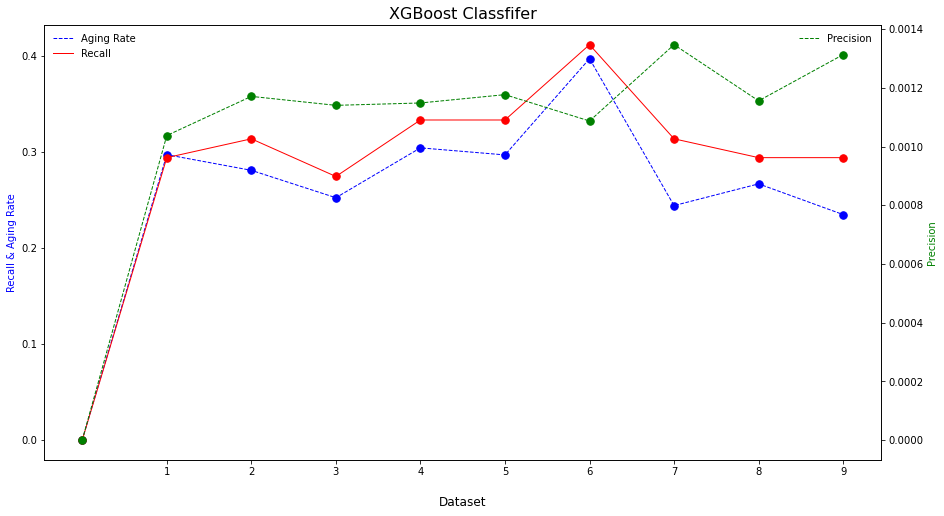

In [6]:
table_setC = runall_XGBoostC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'XGBoost Classfifer')

In [7]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,7.0,51.0,48591.0,0.000000,0.000000,0.000144,0.000000,0.000000
dataset 1,1.000000,3067.0,3067.0,15.0,14444.0,36.0,34154.0,0.001037,0.294118,0.297211,0.989593,0.000000
dataset 2,1.000000,4207.0,4207.0,16.0,13650.0,35.0,34948.0,0.001171,0.313725,0.280910,1.116818,0.235267
dataset 3,1.000000,3336.0,3336.0,14.0,12264.0,37.0,36334.0,0.001140,0.274510,0.252379,1.087688,0.202055
dataset 4,1.000000,3038.0,3038.0,17.0,14787.0,34.0,33811.0,0.001148,0.333333,0.304302,1.095402,0.246582
dataset 5,1.006623,3040.0,3020.0,17.0,14430.0,34.0,34168.0,0.001177,0.333333,0.296964,1.122471,0.250860
dataset 6,0.719016,3040.0,4228.0,21.0,19300.0,30.0,29298.0,0.001087,0.411765,0.397151,1.036796,0.292920
dataset 7,1.000000,3040.0,3040.0,16.0,11863.0,35.0,36735.0,0.001347,0.313725,0.244178,1.284825,0.259228
dataset 8,1.000000,3040.0,3040.0,15.0,12965.0,36.0,35633.0,0.001156,0.294118,0.266809,1.102352,0.218546
dataset 9,10.000000,3040.0,304.0,15.0,11409.0,36.0,37189.0,0.001313,0.294118,0.234825,1.252497,0.238835


### Regression

In [ ]:
pr_dict, table_setR = runall_XGBoostR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'XGBoost Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [8]:
savedate = '20211214'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'XGBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'XGBoost')